In [1]:
from config.config import SQLQuery
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.metrics import roc_auc_score, recall_score, precision_score

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

In [2]:

q = r"""
-----------------DEPENDENT VARIABLE-------------------

with data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2024-02-01'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2024-02-01'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'rejected'
)

,data2_1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID  
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2 as(
select a.*
from data2_1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)


//select target from data2

-----------------BUSINESS DETAILS-------------------

,BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Mar 2022
(
select *
from "PROD_DB"."DATA"."BUSINESSES"
--where ACCOUNT_CREATE_DATE between '2021-01-01' and '2023-03-31'
),


APPLICATION_DETAIL as -- get all entries from applications table
(
select *
from "PROD_DB"."DATA"."APPLICATIONS"
)

, final_query_business as
( select base.BUSINESS_ID,
B.application_id,
B.business_type,
B.email_domain,
B.application_start_datetime,
B.estimated_monthly_revenue,
B.incoming_ach_payments,
B.check_deposit_amount,
B.incoming_wire_transfer,
B.outgoing_ach_and_checks,
B.outgoing_wire_transfers,
B.date_of_establishment,
B.number_of_employees,
B.business_pitch,
B.website,
B.ein_ssn

from BUSINESS_DETAIL base
left join APPLICATION_DETAIL B
on base.APPLICATION_ID = B.APPLICATION_ID
)

,data_business as(
select a.*, b.* exclude(business_id) from data2 a inner join final_query_business b
on a.business_id = b.business_id
)

-----------------AGE OF BUSINESS-------------------

,data_age as(
select a.*, DATEDIFF(day, BUSINESS_CREATED_AT, CREATED_AT)/31 as age_business_months
from data_business a inner join "PROD_DB"."DATA"."BUSINESSES" b
on a.business_id = b.business_id
)


-----------------RUNNING BALANCE 30d-------------------

,rb_data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2024-02-01'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2024-02-01'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'rejected'
)


,all_pfr1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID 
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,all_pfr as(
select a.*
from all_pfr1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

//Calendar
, cal_dates_1 AS (
SELECT DATEADD(DAY, SEQ4(), '2022-04-01') AS CAL_DATE
FROM TABLE(GENERATOR(ROWCOUNT=>640))
ORDER BY CAL_DATE DESC
)

//First Transaction
, biz_dates_1 AS (
SELECT a.BUSINESS_ID, MIN(a.transaction_date) AS FIRST_TXN_DATE
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"  a INNER JOIN  all_pfr b using(business_id)
GROUP BY a.BUSINESS_ID
)

, PILOT_BIZ_DATES_TEMP AS (
SELECT * FROM  cal_dates_1 A LEFT JOIN
biz_dates_1 B ON
date(A.CAL_DATE) >= date(B.FIRST_TXN_DATE)
ORDER BY CAL_DATE ASC
)

// Pull Transactions table
,PILOT_BIZ_TXN_TEMP AS (
SELECT   Business_id ,TRANSACTION_DATE,running_balance FROM
(
SELECT *, RANK () OVER (PARTITION BY BUSINESS_ID,TRANSACTION_DATE ORDER BY timestamp DESC) RANKS
FROM FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"
where 1=1
and status='active'
)
WHERE RANKS=1
order by Business_id, TRANSACTION_DATE
)

,PILOT_DAILY_BALANCES_1  AS (
SELECT BUSINESS_ID,FIRST_TXN_DATE, CAL_DATE,TRANSACTION_DATE,RUNNING_BALANCE,
first_value(RUNNING_BALANCE) OVER (PARTITION BY BUSINESS_ID,GROUPER ORDER BY cal_date asc, TRANSACTION_DATE desc, RUNNING_BALANCE asc nulls last) as RUNNING_BALANCE_2
FROM (
SELECT A.BUSINESS_ID,A.CAL_DATE,A.FIRST_TXN_DATE,
B.TRANSACTION_DATE,B.RUNNING_BALANCE,
COUNT(running_balance) OVER (PARTITION BY a.BUSINESS_ID ORDER BY cal_date asc) as grouper
FROM PILOT_BIZ_DATES_TEMP A LEFT JOIN
PILOT_BIZ_TXN_TEMP B ON
A.BUSINESS_ID=B.BUSINESS_ID AND
date(A.CAL_DATE)= date(B.TRANSACTION_DATE)
ORDER BY A.CAL_DATE ASC)
ORDER BY BUSINESS_ID,CAL_DATE
)

,final_daily_running_balance AS (
SELECT distinct a.business_id, b.id as pfr_id, datediff(day, a.cal_date, b.created_at) as daySincepfr, cal_date, running_balance_2 AS running_balance_daily
FROM  PILOT_DAILY_BALANCES_1  a  INNER JOIN all_pfr b using(business_id)
WHERE daySincepfr > 0 AND daySincepfr <= 30
ORDER BY a.business_id, daySincepfr
)


, rb_30d AS (
SELECT business_id, pfr_id,
sum(CASE WHEN running_balance_daily < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
sum(CASE WHEN running_balance_daily = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
AVG(running_balance_daily) as Avg_running_balance_past30d,
Median(running_balance_daily) as Median_running_balance_past30d,
STDDEV(running_balance_daily) as STDDEV_running_balance_past30d
FROM final_daily_running_balance
GROUP BY business_id, pfr_id
)

-- running balance at the time of deposit
, all_prev_txns as
(select b.business_id, b.id as pfr_id, a.running_balance, created_at,
RANK () OVER (PARTITION BY b.id, created_at ORDER BY timestamp DESC) ranks
from prod_db.data.transactions a inner join all_pfr b
on a.business_id = b.business_id
and a.transaction_date < b.created_at
AND a.STATUS ='active'
)

, latest_running_balance as
(
select business_id, pfr_id, running_balance as rb_at_deposit, created_at
from all_prev_txns
where ranks = 1
)

, final_query_rb as
(
select *
from latest_running_balance left join rb_30d
using (business_id, pfr_id)
)

,running_balance_30d as(
select a.business_id, a.id, a.CREATED_AT, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST30D, b.ZERO_BALANCE_COUNT_PAST30D, b.AVG_RUNNING_BALANCE_PAST30D,
b.MEDIAN_RUNNING_BALANCE_PAST30D, b.STDDEV_RUNNING_BALANCE_PAST30D
from all_pfr a left outer join final_query_rb b on a.id = b.pfr_id
order by a.created_at
)

,data_rb_30d as(
select a.*, b.OD_COUNT_PAST30D, b.ZERO_BALANCE_COUNT_PAST30D, b.AVG_RUNNING_BALANCE_PAST30D, 
b.MEDIAN_RUNNING_BALANCE_PAST30D, b.STDDEV_RUNNING_BALANCE_PAST30D
from data_age a inner join running_balance_30d b
on a.id = b.id)

-----------------RUNNING BALANCE 60d-------------------

,rb_data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2024-02-01'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2024-02-01'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'rejected'
)

,all_pfr1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID 
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,all_pfr as(
select a.*
from all_pfr1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

//Calendar
, cal_dates_1 AS (
SELECT DATEADD(DAY, SEQ4(), '2022-04-01') AS CAL_DATE
FROM TABLE(GENERATOR(ROWCOUNT=>640))
ORDER BY CAL_DATE DESC
)

//First Transaction
, biz_dates_1 AS (
SELECT a.BUSINESS_ID, MIN(a.transaction_date) AS FIRST_TXN_DATE
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"  a INNER JOIN  all_pfr b using(business_id)
GROUP BY a.BUSINESS_ID
)

, PILOT_BIZ_DATES_TEMP AS (
SELECT * FROM  cal_dates_1 A LEFT JOIN
biz_dates_1 B ON
date(A.CAL_DATE) >= date(B.FIRST_TXN_DATE)
ORDER BY CAL_DATE ASC
)

// Pull Transactions table
,PILOT_BIZ_TXN_TEMP AS (
SELECT   Business_id ,TRANSACTION_DATE,running_balance FROM
(
SELECT *, RANK () OVER (PARTITION BY BUSINESS_ID,TRANSACTION_DATE ORDER BY timestamp DESC) RANKS
FROM FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"
where 1=1
and status='active'
)
WHERE RANKS=1
order by Business_id, TRANSACTION_DATE
)

,PILOT_DAILY_BALANCES_1  AS (
SELECT BUSINESS_ID,FIRST_TXN_DATE, CAL_DATE,TRANSACTION_DATE,RUNNING_BALANCE,
first_value(RUNNING_BALANCE) OVER (PARTITION BY BUSINESS_ID,GROUPER ORDER BY cal_date asc, TRANSACTION_DATE desc, RUNNING_BALANCE asc nulls last) as RUNNING_BALANCE_2
FROM (
SELECT A.BUSINESS_ID,A.CAL_DATE,A.FIRST_TXN_DATE,
B.TRANSACTION_DATE,B.RUNNING_BALANCE,
COUNT(running_balance) OVER (PARTITION BY a.BUSINESS_ID ORDER BY cal_date asc) as grouper
FROM PILOT_BIZ_DATES_TEMP A LEFT JOIN
PILOT_BIZ_TXN_TEMP B ON
A.BUSINESS_ID=B.BUSINESS_ID AND
date(A.CAL_DATE)= date(B.TRANSACTION_DATE)
ORDER BY A.CAL_DATE ASC)
ORDER BY BUSINESS_ID,CAL_DATE
)

,final_daily_running_balance_60d AS (
SELECT distinct a.business_id, b.id as pfr_id, datediff(day, a.cal_date, b.created_at) as daySincepfr, cal_date, running_balance_2 AS running_balance_daily
FROM  PILOT_DAILY_BALANCES_1  a  INNER JOIN all_pfr b using(business_id)
WHERE daySincepfr > 0 AND daySincepfr <= 60
ORDER BY a.business_id, daySincepfr
)


, rb_60d AS (
SELECT business_id, pfr_id,
sum(CASE WHEN running_balance_daily < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
sum(CASE WHEN running_balance_daily = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
AVG(running_balance_daily) as Avg_running_balance_past30d,
Median(running_balance_daily) as Median_running_balance_past30d,
STDDEV(running_balance_daily) as STDDEV_running_balance_past30d
FROM final_daily_running_balance_60d
GROUP BY business_id, pfr_id
)

-- running balance at the time of deposit
, all_prev_txns as
(select b.business_id, b.id as pfr_id, a.running_balance, created_at,
RANK () OVER (PARTITION BY b.id, created_at ORDER BY timestamp DESC) ranks
from prod_db.data.transactions a inner join all_pfr b
on a.business_id = b.business_id
and a.transaction_date < b.created_at
AND a.STATUS ='active'
)

, latest_running_balance as
(
select business_id, pfr_id, running_balance as rb_at_deposit, created_at
from all_prev_txns
where ranks = 1
)

, final_query_rb_60d as
(
select *
from latest_running_balance left join rb_60d
using (business_id, pfr_id)
)

,running_balance_60d as(
select a.business_id, a.id, a.CREATED_AT, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST30D as OD_COUNT_PAST60D,
b.ZERO_BALANCE_COUNT_PAST30D as ZERO_BALANCE_COUNT_PAST60D, b.AVG_RUNNING_BALANCE_PAST30D as AVG_RUNNING_BALANCE_PAST60D,
b.MEDIAN_RUNNING_BALANCE_PAST30D as MEDIAN_RUNNING_BALANCE_PAST60D, b.STDDEV_RUNNING_BALANCE_PAST30D as STDDEV_RUNNING_BALANCE_PAST60D
from all_pfr a left outer join final_query_rb_60d b on a.id = b.pfr_id
order by a.created_at
)

,data_running_balance as(
select a.*, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST60D, b.ZERO_BALANCE_COUNT_PAST60D, b.AVG_RUNNING_BALANCE_PAST60D, 
b.MEDIAN_RUNNING_BALANCE_PAST60D, b.STDDEV_RUNNING_BALANCE_PAST60D
from data_rb_30d a inner join running_balance_60d b
on a.id = b.id
)

-------------------ACH FEATURES------------------

,all_ach AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT,

---- STATUS FEATURES -------------------------------------------------------------------------------
CASE WHEN a.status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN a.status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN a.status = 'rejected' THEN 1 ELSE 0 END as is_rejected,
---- TIME FEATURES ---------------------------------------------------------------------------------
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 00 and 5 THEN 1 ELSE 0 end is_midnight,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 6 and 11 THEN 1 ELSE 0 end is_prenoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 12 and 17 THEN 1 ELSE 0 end is_afternoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 18 and 23 THEN 1 ELSE 0 end is_evening,
---- DOLLAR BUCKET FEATURES ------------------------------------------------------------------------
CASE WHEN a.amount >= 00 and a.amount < 100 THEN 1 ELSE 0 end is_lessthan100,
CASE WHEN a.amount >= 100 and a.amount < 250 THEN 1 ELSE 0 end is_between100and250,
CASE WHEN a.amount >= 250 and a.amount < 1200 THEN 1 ELSE 0 end is_between250and1200,
CASE WHEN a.amount >= 1200  THEN 1 ELSE 0 end is_greaterthan1200

FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2024-02-01'
)

,all_ach_2d AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  a.CREATED_AT AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT,

---- STATUS FEATURES -------------------------------------------------------------------------------
CASE WHEN a.status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN a.status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN a.status = 'rejected' THEN 1 ELSE 0 END as is_rejected,
---- TIME FEATURES ---------------------------------------------------------------------------------
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 00 and 5 THEN 1 ELSE 0 end is_midnight,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 6 and 11 THEN 1 ELSE 0 end is_prenoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 12 and 17 THEN 1 ELSE 0 end is_afternoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 18 and 23 THEN 1 ELSE 0 end is_evening,
---- DOLLAR BUCKET FEATURES ------------------------------------------------------------------------
CASE WHEN a.amount >= 00 and a.amount < 100 THEN 1 ELSE 0 end is_lessthan100,
CASE WHEN a.amount >= 100 and a.amount < 250 THEN 1 ELSE 0 end is_between100and250,
CASE WHEN a.amount >= 250 and a.amount < 1200 THEN 1 ELSE 0 end is_between250and1200,
CASE WHEN a.amount >= 1200  THEN 1 ELSE 0 end is_greaterthan1200

FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2024-02-01'
)

--------------- PAST 30 DAY CALCULATIONS -----------------------------------
, past30d_ach as (
select a.*,
past.id as past30d_id,
past.TRANSACTION_ID as past30d_TRANSACTION_ID,
past.USER_ID as past30d_USER_ID,
past.BUSINESS_ID AS past30d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past30d_EXTERNAL_ACCOUNT_ID,
past.amount as past30d_amount,
past.status as past30d_status,

past.is_completed as past30d_is_completed,
past.is_returned as past30d_is_returned,
past.is_rejected as past30d_is_rejected,

past.is_lessthan100 as past30d_is_lessthan100,
past.is_between100and250 as past30d_is_between100and250,
past.is_between250and1200 as past30d_is_between250and1200,
past.is_greaterthan1200 as past30d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-30,a.ach_created_at)
)

, past30d_total_info as (
select BUSINESS_ID,
id,
count(past30d_id) as past30d_ach_count,
avg(past30d_amount) as past30d_avg_ach_amount,
sum(past30d_is_completed) as past30d_completed_ach,
sum(past30d_is_returned)  as past30d_returned_ach,
sum(past30d_is_rejected)  as past30d_rejected_ach,
-- sum(past30d_is_midnight)  as past30d_midnight_count,
-- sum(past30d_is_prenoon)  as past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as past30d_afternoon_count,
-- sum(past30d_is_evening)  as past30d_evening_count,
sum(past30d_is_lessthan100)  as past30d_lessthan100_count,
sum(past30d_is_between100and250)  as past30d_between100and250_count,
sum(past30d_is_between250and1200)  as past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as past30d_greaterthan1200_count

from past30d_ach
group by 1,2
)

, past30d_returned_info as (
select business_id,
id,
count(past30d_id) as returned_past30d_ach_count,
avg(past30d_amount) as returned_past30d_avg_ach_amount,
-- sum(past30d_is_midnight)  as returned_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as returned_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as returned_past30d_afternoon_count,
-- sum(past30d_is_evening)  as returned_past30d_evening_count,
sum(past30d_is_lessthan100)  as returned_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as returned_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as returned_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as returned_past30d_greaterthan1200_count

from past30d_ach
where past30d_status = 'returned'
group by 1,2
)


, past30d_rejected_info as (
select business_id,
id,
count(past30d_id) as rejected_past30d_ach_count,
avg(past30d_amount) as rejected_past30d_avg_ach_amount,
-- sum(past30d_is_midnight)  as rejected_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as rejected_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as rejected_past30d_afternoon_count,
-- sum(past30d_is_evening)  as rejected_past30d_evening_count,
sum(past30d_is_lessthan100)  as rejected_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as rejected_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as rejected_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as rejected_past30d_greaterthan1200_count

from past30d_ach
where past30d_status in ('rejected')
group by 1,2

)


, past30d_completed_info as (
select business_id,
id,
count(past30d_id) as completed_past30d_ach_count,
avg(past30d_amount) as completed_past30d_avg_ach_amount,
stddev(past30d_amount) as completed_past30d_std_ach_amount,
-- sum(past30d_is_midnight)  as completed_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as completed_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as completed_past30d_afternoon_count,
-- sum(past30d_is_evening)  as completed_past30d_evening_count,
sum(past30d_is_lessthan100)  as completed_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as completed_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as completed_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as completed_past30d_greaterthan1200_count

from past30d_ach
where past30d_status = 'completed'
group by 1,2
)

--------------- PAST 60 DAY CALCULATIONS -----------------------------------

, past60d_ach as (
select a.*,
past.id as past60d_id,
past.TRANSACTION_ID as past60d_TRANSACTION_ID,
past.USER_ID as past60d_USER_ID,
past.BUSINESS_ID AS past60d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past60d_EXTERNAL_ACCOUNT_ID,
past.amount as past60d_amount,
past.status as past60d_status,

past.is_completed as past60d_is_completed,
past.is_returned as past60d_is_returned,
past.is_rejected as past60d_is_rejected,

past.is_lessthan100 as past60d_is_lessthan100,
past.is_between100and250 as past60d_is_between100and250,
past.is_between250and1200 as past60d_is_between250and1200,
past.is_greaterthan1200 as past60d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-60,a.ach_created_at)
)

, past60d_total_info as (
select BUSINESS_ID,
id,
count(past60d_id) as past60d_ach_count,
avg(past60d_amount) as past60d_avg_ach_amount,
sum(past60d_is_completed) as past60d_completed_ach,
sum(past60d_is_returned)  as past60d_returned_ach,
sum(past60d_is_rejected)  as past60d_rejected_ach,
-- sum(past60d_is_midnight)  as past60d_midnight_count,
-- sum(past60d_is_prenoon)  as past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as past60d_afternoon_count,
-- sum(past60d_is_evening)  as past60d_evening_count,
sum(past60d_is_lessthan100)  as past60d_lessthan100_count,
sum(past60d_is_between100and250)  as past60d_between100and250_count,
sum(past60d_is_between250and1200)  as past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as past60d_greaterthan1200_count

from past60d_ach
group by 1,2
)

, past60d_returned_info as (
select business_id,
id,
count(past60d_id) as returned_past60d_ach_count,
avg(past60d_amount) as returned_past60d_avg_ach_amount,
-- sum(past60d_is_midnight)  as returned_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as returned_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as returned_past60d_afternoon_count,
-- sum(past60d_is_evening)  as returned_past60d_evening_count,
sum(past60d_is_lessthan100)  as returned_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as returned_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as returned_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as returned_past60d_greaterthan1200_count

from past60d_ach
where past60d_status = 'returned'
group by 1,2
)


, past60d_rejected_info as (
select business_id,
id,
count(past60d_id) as rejected_past60d_ach_count,
avg(past60d_amount) as rejected_past60d_avg_ach_amount,
-- sum(past60d_is_midnight)  as rejected_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as rejected_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as rejected_past60d_afternoon_count,
-- sum(past60d_is_evening)  as rejected_past60d_evening_count,
sum(past60d_is_lessthan100)  as rejected_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as rejected_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as rejected_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as rejected_past60d_greaterthan1200_count

from past60d_ach
where past60d_status in ('rejected')
group by 1,2

)


, past60d_completed_info as (
select business_id,
id,
count(past60d_id) as completed_past60d_ach_count,
avg(past60d_amount) as completed_past60d_avg_ach_amount,
stddev(past60d_amount) as completed_past60d_std_ach_amount,
-- sum(past60d_is_midnight)  as completed_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as completed_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as completed_past60d_afternoon_count,
-- sum(past60d_is_evening)  as completed_past60d_evening_count,
sum(past60d_is_lessthan100)  as completed_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as completed_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as completed_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as completed_past60d_greaterthan1200_count

from past60d_ach
where past60d_status = 'completed'
group by 1,2
)

--------------- PAST 10 DAY CALCULATIONS -----------------------------------

, past10d_ach as (
select a.*,
past.id as past10d_id,
past.TRANSACTION_ID as past10d_TRANSACTION_ID,
past.USER_ID as past10d_USER_ID,
past.BUSINESS_ID AS past10d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past10d_EXTERNAL_ACCOUNT_ID,
past.amount as past10d_amount,
past.status as past10d_status,

past.is_completed as past10d_is_completed,
past.is_returned as past10d_is_returned,
past.is_rejected as past10d_is_rejected,

past.is_lessthan100 as past10d_is_lessthan100,
past.is_between100and250 as past10d_is_between100and250,
past.is_between250and1200 as past10d_is_between250and1200,
past.is_greaterthan1200 as past10d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-10,a.ach_created_at)
)

, past10d_total_info as (
select BUSINESS_ID,
id,
count(past10d_id) as past10d_ach_count,
avg(past10d_amount) as past10d_avg_ach_amount,
sum(past10d_is_completed) as past10d_completed_ach,
sum(past10d_is_returned)  as past10d_returned_ach,
sum(past10d_is_rejected)  as past10d_rejected_ach,
-- sum(past30d_is_midnight)  as past30d_midnight_count,
-- sum(past30d_is_prenoon)  as past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as past30d_afternoon_count,
-- sum(past30d_is_evening)  as past30d_evening_count,
sum(past10d_is_lessthan100)  as past10d_lessthan100_count,
sum(past10d_is_between100and250)  as past10d_between100and250_count,
sum(past10d_is_between250and1200)  as past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as past10d_greaterthan1200_count

from past10d_ach
group by 1,2
)

, past10d_returned_info as (
select business_id,
id,
count(past10d_id) as returned_past10d_ach_count,
avg(past10d_amount) as returned_past10d_avg_ach_amount,
-- sum(past10d_is_midnight)  as returned_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as returned_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as returned_past10d_afternoon_count,
-- sum(past10d_is_evening)  as returned_past10d_evening_count,
sum(past10d_is_lessthan100)  as returned_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as returned_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as returned_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as returned_past10d_greaterthan1200_count

from past10d_ach
where past10d_status = 'returned'
group by 1,2
)


, past10d_rejected_info as (
select business_id,
id,
count(past10d_id) as rejected_past10d_ach_count,
avg(past10d_amount) as rejected_past10d_avg_ach_amount,
-- sum(past10d_is_midnight)  as rejected_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as rejected_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as rejected_past10d_afternoon_count,
-- sum(past10d_is_evening)  as rejected_past10d_evening_count,
sum(past10d_is_lessthan100)  as rejected_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as rejected_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as rejected_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as rejected_past10d_greaterthan1200_count

from past10d_ach
where past10d_status in ('rejected')
group by 1,2
)


, past10d_completed_info as (
select business_id,
id,
count(past10d_id) as completed_past10d_ach_count,
avg(past10d_amount) as completed_past10d_avg_ach_amount,
stddev(past10d_amount) as completed_past10d_std_ach_amount,
-- sum(past10d_is_midnight)  as completed_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as completed_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as completed_past10d_afternoon_count,
-- sum(past10d_is_evening)  as completed_past10d_evening_count,
sum(past10d_is_lessthan100)  as completed_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as completed_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as completed_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as completed_past10d_greaterthan1200_count

from past10d_ach
where past10d_status = 'completed'
group by 1,2
)

--------------- PAST 90 DAY CALCULATIONS -----------------------------------

, past90d_ach as (
select a.*,
past.id as past90d_id,
past.TRANSACTION_ID as past90d_TRANSACTION_ID,
past.USER_ID as past90d_USER_ID,
past.BUSINESS_ID AS past90d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past90d_EXTERNAL_ACCOUNT_ID,
past.amount as past90d_amount,
past.status as past90d_status,

past.is_completed as past90d_is_completed,
past.is_returned as past90d_is_returned,
past.is_rejected as past90d_is_rejected,

past.is_lessthan100 as past90d_is_lessthan100,
past.is_between100and250 as past90d_is_between100and250,
past.is_between250and1200 as past90d_is_between250and1200,
past.is_greaterthan1200 as past90d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-90,a.ach_created_at)
)

, past90d_total_info as (
select BUSINESS_ID,
id,
count(past90d_id) as past90d_ach_count,
avg(past90d_amount) as past90d_avg_ach_amount,
sum(past90d_is_completed) as past90d_completed_ach,
sum(past90d_is_returned)  as past90d_returned_ach,
sum(past90d_is_rejected)  as past90d_rejected_ach,
-- sum(past90d_is_midnight)  as past90d_midnight_count,
-- sum(past90d_is_prenoon)  as past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as past90d_afternoon_count,
-- sum(past90d_is_evening)  as past90d_evening_count,
sum(past90d_is_lessthan100)  as past90d_lessthan100_count,
sum(past90d_is_between100and250)  as past90d_between100and250_count,
sum(past90d_is_between250and1200)  as past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as past90d_greaterthan1200_count

from past90d_ach
group by 1,2
)

, past90d_returned_info as (
select business_id,
id,
count(past90d_id) as returned_past90d_ach_count,
avg(past90d_amount) as returned_past90d_avg_ach_amount,
-- sum(past90d_is_midnight)  as returned_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as returned_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as returned_past90d_afternoon_count,
-- sum(past90d_is_evening)  as returned_past90d_evening_count,
sum(past90d_is_lessthan100)  as returned_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as returned_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as returned_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as returned_past90d_greaterthan1200_count

from past90d_ach
where past90d_status = 'returned'
group by 1,2
)


, past90d_rejected_info as (
select business_id,
id,
count(past90d_id) as rejected_past90d_ach_count,
avg(past90d_amount) as rejected_past90d_avg_ach_amount,
-- sum(past90d_is_midnight)  as rejected_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as rejected_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as rejected_past90d_afternoon_count,
-- sum(past90d_is_evening)  as rejected_past90d_evening_count,
sum(past90d_is_lessthan100)  as rejected_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as rejected_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as rejected_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as rejected_past90d_greaterthan1200_count

from past90d_ach
where past90d_status in ('rejected')
group by 1,2

)


, past90d_completed_info as (
select business_id,
id,
count(past90d_id) as completed_past90d_ach_count,
avg(past90d_amount) as completed_past90d_avg_ach_amount,
stddev(past90d_amount) as completed_past90d_std_ach_amount,
-- sum(past90d_is_midnight)  as completed_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as completed_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as completed_past90d_afternoon_count,
-- sum(past90d_is_evening)  as completed_past90d_evening_count,
sum(past90d_is_lessthan100)  as completed_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as completed_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as completed_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as completed_past90d_greaterthan1200_count

from past90d_ach
where past90d_status = 'completed'
group by 1,2
)

--------------- PAST 2 DAY CALCULATIONS -----------------------------------
, past_2d_ach as (
select a.*,
past.id as past_2d_id,
past.TRANSACTION_ID as past_2d_TRANSACTION_ID,
past.USER_ID as past_2d_USER_ID,
past.BUSINESS_ID AS past_2d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past_2d_EXTERNAL_ACCOUNT_ID,
past.amount as past_2d_amount,
past.status as past_2d_status,

past.is_completed as past_2d_is_completed,
past.is_returned as past_2d_is_returned,
past.is_rejected as past_2d_is_rejected,

past.is_lessthan100 as past_2d_is_lessthan100,
past.is_between100and250 as past_2d_is_between100and250,
past.is_between250and1200 as past_2d_is_between250and1200,
past.is_greaterthan1200 as past_2d_is_greaterthan1200

from all_ach_2d a inner join all_ach_2d past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-2,a.ach_created_at)
)

, past_2d_total_info as (
select BUSINESS_ID,
id,
count(past_2d_id) as past_2d_ach_count,
avg(past_2d_amount) as past_2d_avg_ach_amount,
//       sum(past_2d_is_completed) as past_2d_completed_ach,
//       sum(past_2d_is_returned)  as past_2d_returned_ach,
//       sum(past_2d_is_rejected)  as past_2d_rejected_ach,
-- sum(past_2d_is_midnight)  as past_2d_midnight_count,
-- sum(past_2d_is_prenoon)  as past_2d_prenoon_count,
-- sum(past_2d_is_afternoon)  as past_2d_afternoon_count,
-- sum(past_2d_is_evening)  as past_2d_evening_count,
sum(past_2d_is_lessthan100)  as past_2d_lessthan100_count,
sum(past_2d_is_between100and250)  as past_2d_between100and250_count,
sum(past_2d_is_between250and1200)  as past_2d_between250and1200_count,
sum(past_2d_is_greaterthan1200)  as past_2d_greaterthan1200_count

from past_2d_ach
group by 1,2
)

//, past_2d_returned_info as (
// select business_id,
//       id,
//       count(past_2d_id) as returned_past_2d_ach_count,
//       avg(past_2d_amount) as returned_past_2d_avg_ach_amount,
//       -- sum(past_2d_is_midnight)  as returned_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as returned_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as returned_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as returned_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as returned_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as returned_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as returned_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as returned_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status = 'returned'
//group by 1,2
//)


//, past_2d_rejected_info as (
// select business_id,
//       id,
//       count(past_2d_id) as rejected_past_2d_ach_count,
//       avg(past_2d_amount) as rejected_past_2d_avg_ach_amount,
//       -- sum(past_2d_is_midnight)  as rejected_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as rejected_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as rejected_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as rejected_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as rejected_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as rejected_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as rejected_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as rejected_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status in ('rejected')
//group by 1,2
//
//)


//, past_2d_completed_info as (
// select business_id,
//       id,
//       count(past_2d_id) as completed_past_2d_ach_count,
//       avg(past_2d_amount) as completed_past_2d_avg_ach_amount,
//       stddev(past_2d_amount) as completed_past_2d_std_ach_amount,
//       -- sum(past_2d_is_midnight)  as completed_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as completed_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as completed_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as completed_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as completed_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as completed_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as completed_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as completed_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status = 'completed'
//group by 1,2
//)

,data_ach_features as (
select meta.BUSINESS_ID, meta.ID as pfr_id, meta.TRANSACTION_ID, meta.USER_ID, meta.EXTERNAL_ACCOUNT_ID,

------- Past 30d day features -----------------------------------------------------------------------------------
COALESCE(past30d_ach_count,0) as past30d_ach_count,
COALESCE(past30d_avg_ach_amount,0) as past30d_avg_ach_amount,

COALESCE(past30d_completed_ach,0) as past30d_completed_ach,
COALESCE(past30d_returned_ach,0) as past30d_returned_ach,
COALESCE(past30d_rejected_ach,0) as past30d_rejected_ach,

COALESCE(past30d_lessthan100_count,0)  as past30d_lessthan100_count,
COALESCE(past30d_between100and250_count,0)  as past30d_between100and250_count,
COALESCE(past30d_between250and1200_count,0)  as past30d_between250and1200_count,
COALESCE(past30d_greaterthan1200_count,0)  as past30d_greaterthan1200_count,

COALESCE(returned_past30d_ach_count,0) as  returned_past30d_ach_count,
COALESCE(returned_past30d_avg_ach_amount,0) as  returned_past30d_avg_ach_amount,
COALESCE(returned_past30d_lessthan100_count,0)  as returned_past30d_lessthan100_count,
COALESCE(returned_past30d_between100and250_count,0)  as returned_past30d_between100and250_count,
COALESCE(returned_past30d_between250and1200_count,0)  as returned_past30d_between250and1200_count,
COALESCE(returned_past30d_greaterthan1200_count,0)  as returned_past30d_greaterthan1200_count,

COALESCE(rejected_past30d_ach_count,0) as  rejected_past30d_ach_count,
COALESCE(rejected_past30d_avg_ach_amount,0) as  rejected_past30d_avg_ach_amount,
COALESCE(rejected_past30d_lessthan100_count,0)  as rejected_past30d_lessthan100_count,
COALESCE(rejected_past30d_between100and250_count,0)  as rejected_past30d_between100and250_count,
COALESCE(rejected_past30d_between250and1200_count,0)  as rejected_past30d_between250and1200_count,
COALESCE(rejected_past30d_greaterthan1200_count,0) as rejected_past30d_greaterthan1200_count,

COALESCE(completed_past30d_ach_count,0) as completed_past30d_ach_count,
COALESCE(completed_past30d_avg_ach_amount,0) as completed_past30d_avg_ach_amount,
COALESCE(completed_past30d_std_ach_amount,0) as completed_past30d_std_ach_amount,
amount/(completed_past30d_avg_ach_amount + 1) as  completed_past30d_vs_current_amount_score,
(amount-completed_past30d_avg_ach_amount)/(completed_past30d_avg_ach_amount + 1)
as completed_past30d_moving_avg_dev_amount,
COALESCE(completed_past30d_lessthan100_count,0)  as completed_past30d_lessthan100_count,
COALESCE(completed_past30d_between100and250_count,0)  as completed_past30d_between100and250_count,
COALESCE(completed_past30d_between250and1200_count,0)  as completed_past30d_between250and1200_count,
COALESCE(completed_past30d_greaterthan1200_count,0)  as completed_past30d_greaterthan1200_count,

------- Past 60d day features -----------------------------------------------------------------------------------
COALESCE(past60d_ach_count,0) as past60d_ach_count,
COALESCE(past60d_avg_ach_amount,0) as past60d_avg_ach_amount,

COALESCE(past60d_completed_ach,0) as past60d_completed_ach,
COALESCE(past60d_returned_ach,0) as past60d_returned_ach,
COALESCE(past60d_rejected_ach,0) as past60d_rejected_ach,

COALESCE(past60d_lessthan100_count,0)  as past60d_lessthan100_count,
COALESCE(past60d_between100and250_count,0)  as past60d_between100and250_count,
COALESCE(past60d_between250and1200_count,0)  as past60d_between250and1200_count,
COALESCE(past60d_greaterthan1200_count,0)  as past60d_greaterthan1200_count,

COALESCE(returned_past60d_ach_count,0) as  returned_past60d_ach_count,
COALESCE(returned_past60d_avg_ach_amount,0) as  returned_past60d_avg_ach_amount,
COALESCE(returned_past60d_lessthan100_count,0)  as returned_past60d_lessthan100_count,
COALESCE(returned_past60d_between100and250_count,0)  as returned_past60d_between100and250_count,
COALESCE(returned_past60d_between250and1200_count,0)  as returned_past60d_between250and1200_count,
COALESCE(returned_past60d_greaterthan1200_count,0)  as returned_past60d_greaterthan1200_count,

COALESCE(rejected_past60d_ach_count,0) as  rejected_past60d_ach_count,
COALESCE(rejected_past60d_avg_ach_amount,0) as  rejected_past60d_avg_ach_amount,
COALESCE(rejected_past60d_lessthan100_count,0)  as rejected_past60d_lessthan100_count,
COALESCE(rejected_past60d_between100and250_count,0)  as rejected_past60d_between100and250_count,
COALESCE(rejected_past60d_between250and1200_count,0)  as rejected_past60d_between250and1200_count,
COALESCE(rejected_past60d_greaterthan1200_count,0) as rejected_past60d_greaterthan1200_count,

COALESCE(completed_past60d_ach_count,0) as completed_past60d_ach_count,
COALESCE(completed_past60d_avg_ach_amount,0) as completed_past60d_avg_ach_amount,
COALESCE(completed_past60d_std_ach_amount,0) as completed_past60d_std_ach_amount,
amount/(completed_past60d_avg_ach_amount + 1) as  completed_past60d_vs_current_amount_score,
(amount-completed_past60d_avg_ach_amount)/(completed_past60d_avg_ach_amount + 1)
as completed_past60d_moving_avg_dev_amount,
COALESCE(completed_past60d_lessthan100_count,0)  as completed_past60d_lessthan100_count,
COALESCE(completed_past60d_between100and250_count,0)  as completed_past60d_between100and250_count,
COALESCE(completed_past60d_between250and1200_count,0)  as completed_past60d_between250and1200_count,
COALESCE(completed_past60d_greaterthan1200_count,0)  as completed_past60d_greaterthan1200_count,

------- Past 10d day features -----------------------------------------------------------------------------------
COALESCE(past10d_ach_count,0) as past10d_ach_count,
COALESCE(past10d_avg_ach_amount,0) as past10d_avg_ach_amount,

COALESCE(past10d_completed_ach,0) as past10d_completed_ach,
COALESCE(past10d_returned_ach,0) as past10d_returned_ach,
COALESCE(past10d_rejected_ach,0) as past10d_rejected_ach,

COALESCE(past10d_lessthan100_count,0)  as past10d_lessthan100_count,
COALESCE(past10d_between100and250_count,0)  as past10d_between100and250_count,
COALESCE(past10d_between250and1200_count,0)  as past10d_between250and1200_count,
COALESCE(past10d_greaterthan1200_count,0)  as past10d_greaterthan1200_count,

COALESCE(returned_past10d_ach_count,0) as  returned_past10d_ach_count,
COALESCE(returned_past10d_avg_ach_amount,0) as  returned_past10d_avg_ach_amount,
COALESCE(returned_past10d_lessthan100_count,0)  as returned_past10d_lessthan100_count,
COALESCE(returned_past10d_between100and250_count,0)  as returned_past10d_between100and250_count,
COALESCE(returned_past10d_between250and1200_count,0)  as returned_past10d_between250and1200_count,
COALESCE(returned_past10d_greaterthan1200_count,0)  as returned_past10d_greaterthan1200_count,

COALESCE(rejected_past10d_ach_count,0) as  rejected_past10d_ach_count,
COALESCE(rejected_past10d_avg_ach_amount,0) as  rejected_past10d_avg_ach_amount,
COALESCE(rejected_past10d_lessthan100_count,0)  as rejected_past10d_lessthan100_count,
COALESCE(rejected_past10d_between100and250_count,0)  as rejected_past10d_between100and250_count,
COALESCE(rejected_past10d_between250and1200_count,0)  as rejected_past10d_between250and1200_count,
COALESCE(rejected_past10d_greaterthan1200_count,0) as rejected_past10d_greaterthan1200_count,

COALESCE(completed_past10d_ach_count,0) as completed_past10d_ach_count,
COALESCE(completed_past10d_avg_ach_amount,0) as completed_past10d_avg_ach_amount,
COALESCE(completed_past10d_std_ach_amount,0) as completed_past10d_std_ach_amount,
amount/(completed_past10d_avg_ach_amount + 1) as  completed_past10d_vs_current_amount_score,
(amount-completed_past10d_avg_ach_amount)/(completed_past10d_avg_ach_amount + 1)
as completed_past10d_moving_avg_dev_amount,
COALESCE(completed_past10d_lessthan100_count,0)  as completed_past10d_lessthan100_count,
COALESCE(completed_past10d_between100and250_count,0)  as completed_past10d_between100and250_count,
COALESCE(completed_past10d_between250and1200_count,0)  as completed_past10d_between250and1200_count,
COALESCE(completed_past10d_greaterthan1200_count,0)  as completed_past10d_greaterthan1200_count,


------- Past 90d day features -----------------------------------------------------------------------------------
COALESCE(past90d_ach_count,0) as past90d_ach_count,
COALESCE(past90d_avg_ach_amount,0) as past90d_avg_ach_amount,

COALESCE(past90d_completed_ach,0) as past90d_completed_ach,
COALESCE(past90d_returned_ach,0) as past90d_returned_ach,
COALESCE(past90d_rejected_ach,0) as past90d_rejected_ach,

COALESCE(past90d_lessthan100_count,0)  as past90d_lessthan100_count,
COALESCE(past90d_between100and250_count,0)  as past90d_between100and250_count,
COALESCE(past90d_between250and1200_count,0)  as past90d_between250and1200_count,
COALESCE(past90d_greaterthan1200_count,0)  as past90d_greaterthan1200_count,

COALESCE(returned_past90d_ach_count,0) as  returned_past90d_ach_count,
COALESCE(returned_past90d_avg_ach_amount,0) as  returned_past90d_avg_ach_amount,
COALESCE(returned_past90d_lessthan100_count,0)  as returned_past90d_lessthan100_count,
COALESCE(returned_past90d_between100and250_count,0)  as returned_past90d_between100and250_count,
COALESCE(returned_past90d_between250and1200_count,0)  as returned_past90d_between250and1200_count,
COALESCE(returned_past90d_greaterthan1200_count,0)  as returned_past90d_greaterthan1200_count,

COALESCE(rejected_past90d_ach_count,0) as  rejected_past90d_ach_count,
COALESCE(rejected_past90d_avg_ach_amount,0) as  rejected_past90d_avg_ach_amount,
COALESCE(rejected_past90d_lessthan100_count,0)  as rejected_past90d_lessthan100_count,
COALESCE(rejected_past90d_between100and250_count,0)  as rejected_past90d_between100and250_count,
COALESCE(rejected_past90d_between250and1200_count,0)  as rejected_past90d_between250and1200_count,
COALESCE(rejected_past90d_greaterthan1200_count,0) as rejected_past90d_greaterthan1200_count,

COALESCE(completed_past90d_ach_count,0) as completed_past90d_ach_count,
COALESCE(completed_past90d_avg_ach_amount,0) as completed_past90d_avg_ach_amount,
COALESCE(completed_past90d_std_ach_amount,0) as completed_past90d_std_ach_amount,
amount/(completed_past90d_avg_ach_amount + 1) as  completed_past90d_vs_current_amount_score,
(amount-completed_past90d_avg_ach_amount)/(completed_past90d_avg_ach_amount + 1)
as completed_past90d_moving_avg_dev_amount,
COALESCE(completed_past90d_lessthan100_count,0)  as completed_past90d_lessthan100_count,
COALESCE(completed_past90d_between100and250_count,0)  as completed_past90d_between100and250_count,
COALESCE(completed_past90d_between250and1200_count,0)  as completed_past90d_between250and1200_count,
COALESCE(completed_past90d_greaterthan1200_count,0)  as completed_past90d_greaterthan1200_count,


------- Past 2d day features -----------------------------------------------------------------------------------
COALESCE(past_2d_ach_count,0) as past_2d_ach_count,
COALESCE(past_2d_avg_ach_amount,0) as past_2d_avg_ach_amount,

//       COALESCE(past_2d_completed_ach,0) as past_2d_completed_ach,
//       COALESCE(past_2d_returned_ach,0) as past_2d_returned_ach,
//       COALESCE(past_2d_rejected_ach,0) as past_2d_rejected_ach,

COALESCE(past_2d_lessthan100_count,0)  as past_2d_lessthan100_count,
COALESCE(past_2d_between100and250_count,0)  as past_2d_between100and250_count,
COALESCE(past_2d_between250and1200_count,0)  as past_2d_between250and1200_count,
COALESCE(past_2d_greaterthan1200_count,0)  as past_2d_greaterthan1200_count

//       COALESCE(returned_past_2d_ach_count,0) as  returned_past_2d_ach_count,
//       COALESCE(returned_past_2d_avg_ach_amount,0) as  returned_past_2d_avg_ach_amount,
//       COALESCE(returned_past_2d_lessthan100_count,0)  as returned_past_2d_lessthan100_count,
//       COALESCE(returned_past_2d_between100and250_count,0)  as returned_past_2d_between100and250_count,
//       COALESCE(returned_past_2d_between250and1200_count,0)  as returned_past_2d_between250and1200_count,
//
//       COALESCE(rejected_past_2d_ach_count,0) as  rejected_past_2d_ach_count,
//       COALESCE(rejected_past_2d_avg_ach_amount,0) as  rejected_past_2d_avg_ach_amount,
//       COALESCE(rejected_past_2d_lessthan100_count,0)  as rejected_past_2d_lessthan100_count,
//       COALESCE(rejected_past_2d_between100and250_count,0)  as rejected_past_2d_between100and250_count,
//       COALESCE(rejected_past_2d_between250and1200_count,0)  as rejected_past_2d_between250and1200_count,
//       COALESCE(rejected_past_2d_greaterthan1200_count,0) as rejected_past_2d_greaterthan1200_count,
//
//       COALESCE(completed_past_2d_ach_count,0) as completed_past_2d_ach_count,
//       COALESCE(completed_past_2d_avg_ach_amount,0) as completed_past_2d_avg_ach_amount,
//       COALESCE(completed_past_2d_std_ach_amount,0) as completed_past_2d_std_ach_amount,
//       amount/(completed_past_2d_avg_ach_amount + 1) as  completed_past_2d_vs_current_amount_score,
//       (amount-completed_past_2d_avg_ach_amount)/(completed_past_2d_avg_ach_amount + 1)
//       as completed_past_2d_moving_avg_dev_amount,
//       COALESCE(completed_past_2d_lessthan100_count,0)  as completed_past_2d_lessthan100_count,
//       COALESCE(completed_past_2d_between100and250_count,0)  as completed_past_2d_between100and250_count,
//       COALESCE(completed_past_2d_between250and1200_count,0)  as completed_past_2d_between250and1200_count,
//       COALESCE(completed_past_2d_greaterthan1200_count,0)  as completed_past_2d_greaterthan1200_count

//collate everything
from all_ach meta left join
past30d_total_info using (business_id, ID)left join
past30d_returned_info  using (business_id, ID) left join
past30d_rejected_info  using (business_id, ID) left join
past30d_completed_info  using (business_id, ID) left join

past60d_total_info using (business_id, ID)left join
past60d_returned_info  using (business_id, ID) left join
past60d_rejected_info  using (business_id, ID) left join
past60d_completed_info  using (business_id, ID) left join

past10d_total_info using (business_id, ID)left join
past10d_returned_info  using (business_id, ID) left join
past10d_rejected_info  using (business_id, ID) left join
past10d_completed_info  using (business_id, ID) left join

past90d_total_info using (business_id, ID)left join
past90d_returned_info  using (business_id, ID) left join
past90d_rejected_info  using (business_id, ID) left join
past90d_completed_info  using (business_id, ID) left join

past_2d_total_info using (business_id, ID)
)

,data_ach_features_2 as(
select * exclude(business_id, TRANSACTION_ID, USER_ID, EXTERNAL_ACCOUNT_ID) from data_ach_features
)

,data_ach as (
select a.*, b.* exclude(pfr_id)
from data_running_balance a inner join data_ach_features_2 b
on a.id = b.pfr_id
)
--------Transactions---------

,all_pfr_transaction AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  a.CREATED_AT AS pfr_created_at,
a.created_at, a.STATUS, a.AMOUNT
FROM "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2024-02-01'
)

, pfr_past_txn_past30d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0 -- a.transaction_date < b.pfr_created_at
and datediff(day, a.transaction_date, b.pfr_created_at) <= 30
and a.status='active'
)

, pfr_past_txn_past60d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0 
and datediff(day, a.transaction_date, b.pfr_created_at) <= 60
and a.status='active'
)

, pfr_past_txn_past10d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0
and datediff(day, a.transaction_date, b.pfr_created_at) <= 10
and a.status='active'
)

, pfr_past_txn_past2d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) >= 0
and datediff(day, a.transaction_date, b.pfr_created_at) <= 2
and a.status='active'
)


, pfr_past_txn_agg_past30d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past30d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past30d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past30d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past30d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past30d,
sum(is_ach_c) as ach_c_count_past30d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past30d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past30d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past30d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past30d,
sum(is_ach_d) as ach_d_count_past30d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past30d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past30d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past30d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past30d,
sum(is_mrdc_d) as mrdc_d_count_past30d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past30d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past30d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past30d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past30d,
sum(is_mrdc_c) as mrdc_c_count_past30d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past30d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past30d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past30d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past30d,
sum(is_credit) as credit_txn_count_past30d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_30d,
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past30d,
avg(abs(amount)*is_credit) as credit_txn_avg_past30d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past30d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past30d,
sum(is_debit) as debit_txn_count_past30d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past30d,
avg(abs(amount)*is_debit) as debit_txn_avg_past30d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past30d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past30d,
sum(is_pd_txn) as pd_count_past30d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past30d,
avg(abs(amount)*is_pd_txn) as pd_avg_past30d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past30d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past30d
from pfr_past_txn_past30d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past60d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past60d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past60d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past60d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past60d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past60d,
sum(is_ach_c) as ach_c_count_past60d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past60d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past60d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past60d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past60d,
sum(is_ach_d) as ach_d_count_past60d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past60d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past60d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past60d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past60d,
sum(is_mrdc_d) as mrdc_d_count_past60d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past60d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past60d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past60d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past60d,
sum(is_mrdc_c) as mrdc_c_count_past60d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past60d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past60d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past60d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past60d,
sum(is_credit) as credit_txn_count_past60d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_60d, 
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past60d,
avg(abs(amount)*is_credit) as credit_txn_avg_past60d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past60d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past60d,
sum(is_debit) as debit_txn_count_past60d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past60d,
avg(abs(amount)*is_debit) as debit_txn_avg_past60d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past60d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past60d,
sum(is_pd_txn) as pd_count_past60d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past60d,
avg(abs(amount)*is_pd_txn) as pd_avg_past60d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past60d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past60d
from pfr_past_txn_past60d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past10d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past10d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past10d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past10d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past10d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past10d,
sum(is_ach_c) as ach_c_count_past10d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past10d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past10d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past10d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past10d,
sum(is_ach_d) as ach_d_count_past10d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past10d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past10d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past10d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past10d,
sum(is_mrdc_d) as mrdc_d_count_past10d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past10d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past10d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past10d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past10d,
sum(is_mrdc_c) as mrdc_c_count_past10d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past10d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past10d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past10d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past10d,
sum(is_credit) as credit_txn_count_past10d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_10d,
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past10d,
avg(abs(amount)*is_credit) as credit_txn_avg_past10d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past10d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past10d,
sum(is_debit) as debit_txn_count_past10d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past10d,
avg(abs(amount)*is_debit) as debit_txn_avg_past10d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past10d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past10d,
sum(is_pd_txn) as pd_count_past10d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past10d,
avg(abs(amount)*is_pd_txn) as pd_avg_past10d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past10d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past10d
from pfr_past_txn_past10d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past2d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past2d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past2d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past2d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past2d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past2d,
sum(is_ach_c) as ach_c_count_past2d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past2d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past2d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past2d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past2d,
sum(is_ach_d) as ach_d_count_past2d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past2d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past2d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past2d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past2d,
sum(is_mrdc_d) as mrdc_d_count_past2d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past2d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past2d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past2d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past2d,
sum(is_mrdc_c) as mrdc_c_count_past2d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past2d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past2d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past2d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past2d,
sum(is_credit) as credit_txn_count_past2d,
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past2d,
avg(abs(amount)*is_credit) as credit_txn_avg_past2d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past2d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past2d,
sum(is_debit) as debit_txn_count_past2d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past2d,
avg(abs(amount)*is_debit) as debit_txn_avg_past2d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past2d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past2d,
sum(is_pd_txn) as pd_count_past2d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past2d,
avg(abs(amount)*is_pd_txn) as pd_avg_past2d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past2d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past2d
from pfr_past_txn_past2d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, final_query_txn as
(
select *,
DIV0NULL(card_txn_count_past10d,card_txn_count_past30d) as card_txn_count_past10by30d,
DIV0NULL(card_txn_median_past10d,card_txn_median_past30d) as card_txn_median_past10by30d,
DIV0NULL(card_txn_avg_past10d,card_txn_avg_past30d) as card_txn_avg_past10by30d,
DIV0NULL(card_txn_std_past10d,card_txn_std_past30d) as card_txn_std_past10by30d,
DIV0NULL(card_txn_amt_per_txn_past10d,card_txn_amt_per_txn_past30d) as card_txn_amt_per_txn_past10by30d,
DIV0NULL(ach_c_count_past10d,ach_c_count_past30d) as ach_c_count_past10by30d,
DIV0NULL(ach_c_median_past10d,ach_c_median_past30d) as ach_c_median_past10by30d,
DIV0NULL(ach_c_avg_past10d,ach_c_avg_past30d) as ach_c_avg_past10by30d,
DIV0NULL(ach_c_std_past10d,ach_c_std_past30d) as ach_c_std_past10by30d,
DIV0NULL(ach_c_amt_per_txn_past10d,ach_c_amt_per_txn_past30d) as ach_c_amt_per_txn_past10by30d,
DIV0NULL(ach_d_count_past10d,ach_d_count_past30d) as ach_d_count_past10by30d,
DIV0NULL(ach_d_median_past10d,ach_d_median_past30d) as ach_d_median_past10by30d,
DIV0NULL(ach_d_avg_past10d,ach_d_avg_past30d) as ach_d_avg_past10by30d,
DIV0NULL(ach_d_std_past10d,ach_d_std_past30d) as ach_d_std_past10by30d,
DIV0NULL(ach_d_amt_per_txn_past10d,ach_d_amt_per_txn_past30d) as ach_d_amt_per_txn_past10by30d,
DIV0NULL(mrdc_d_count_past10d,mrdc_d_count_past30d) as mrdc_d_count_past10by30d,
DIV0NULL(mrdc_d_median_past10d,mrdc_d_median_past30d) as mrdc_d_median_past10by30d,
DIV0NULL(mrdc_d_avg_past10d,mrdc_d_avg_past30d) as mrdc_d_avg_past10by30d,
DIV0NULL(mrdc_d_std_past10d,mrdc_d_std_past30d) as mrdc_d_std_past10by30d,
DIV0NULL(mrdc_d_amt_per_txn_past10d,mrdc_d_amt_per_txn_past30d) as mrdc_d_amt_per_txn_past10by30d,
DIV0NULL(mrdc_c_count_past10d,mrdc_c_count_past30d) as mrdc_c_count_past10by30d,
DIV0NULL(mrdc_c_median_past10d,mrdc_c_median_past30d) as mrdc_c_median_past10by30d,
DIV0NULL(mrdc_c_avg_past10d,mrdc_c_avg_past30d) as mrdc_c_avg_past10by30d,
DIV0NULL(mrdc_c_std_past10d,mrdc_c_std_past30d) as mrdc_c_std_past10by30d,
DIV0NULL(mrdc_c_amt_per_txn_past10d,mrdc_c_amt_per_txn_past30d) as mrdc_c_amt_per_txn_past10by30d,
DIV0NULL(credit_txn_count_past10d,credit_txn_count_past30d) as credit_txn_count_past10by30d,
DIV0NULL(credit_txn_median_past10d,credit_txn_median_past30d) as credit_txn_median_past10by30d,
DIV0NULL(credit_txn_avg_past10d,credit_txn_avg_past30d) as credit_txn_avg_past10by30d,
DIV0NULL(credit_txn_std_past10d,credit_txn_std_past30d) as credit_txn_std_past10by30d,
DIV0NULL(credit_txn_amt_per_txn_past10d,credit_txn_amt_per_txn_past30d) as credit_txn_amt_per_txn_past10by30d,
DIV0NULL(debit_txn_count_past10d,debit_txn_count_past30d) as debit_txn_count_past10by30d,
DIV0NULL(debit_txn_median_past10d,debit_txn_median_past30d) as debit_txn_median_past10by30d,
DIV0NULL(debit_txn_avg_past10d,debit_txn_avg_past30d) as debit_txn_avg_past10by30d,
DIV0NULL(debit_txn_std_past10d,debit_txn_std_past30d) as debit_txn_std_past10by30d,
DIV0NULL(debit_txn_amt_per_txn_past10d,debit_txn_amt_per_txn_past30d) as debit_txn_amt_per_txn_past10by30d,
DIV0NULL(pd_count_past10d,pd_count_past30d) as pd_count_past10by30d,
DIV0NULL(pd_median_past10d,pd_median_past30d) as pd_median_past10by30d,
DIV0NULL(pd_avg_past10d,pd_avg_past30d) as pd_avg_past10by30d,
DIV0NULL(pd_std_past10d,pd_std_past30d) as pd_std_past10by30d,
DIV0NULL(pd_amt_per_txn_past10d,pd_amt_per_txn_past30d) as pd_amt_per_txn_past10by30d
from
pfr_past_txn_agg_past30d left join pfr_past_txn_agg_past60d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
left join pfr_past_txn_agg_past10d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
left join pfr_past_txn_agg_past2d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
)

, ach_transactions as (
select a.*, b.* exclude(PFR_ID, PFR_TRANSACTION_ID, BUSINESS_ID, PFR_STATUS)
from data_ach a inner join final_query_txn b
on a.id = b.pfr_id
)

------------LIMIT UTILISATION------------

,all_ach_limit AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT
FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2024-02-01'
)

,daily_limit as(
select *, JSON_EXTRACT_PATH_TEXT(META:product:ach:pull:hard,'dailyItemAmount') as daily_limit
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LIMITS"
order by daily_limit
)

,utilisation as(
select a.*, DAILY_LIMIT, amount/DAILY_LIMIT as utilisation,
CASE WHEN daily_limit <= 1200 THEN 'LOW'
WHEN daily_limit>1200 and daily_limit <=4999 THEN 'MID'
WHEN daily_limit>=5000 THEN 'HIGH' end as limit_categories
from all_ach_limit a inner join daily_limit b on a.business_id = b.business_id
//where a.business_id = '3a84769d-a584-4243-8a70-66acfce6b907'
)

,all_ach_limit1 AS (
select
a.id as pfr_id, a.TRANSACTION_ID as pfr_transaction_id, a.USER_ID, a.BUSINESS_ID as pfr_business_id, 
a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS as pfr_status, a.AMOUNT
FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2024-02-01'
)

,utilisation_interim as (
select a.*, b.*,
case when utilisation > 0.8 then 1 else 0 end max_utilisation
from all_ach_limit1 a left join utilisation b
on a.pfr_business_id = b.business_id
and datediff(day, a.ACH_CREATED_AT, b.ACH_CREATED_AT) >= 0 -- a.transaction_date < b.pfr_created_at
and datediff(day, a.ACH_CREATED_AT, b.ACH_CREATED_AT) <= 60
)

,utilisation2 as(
select ID, TRANSACTION_ID, business_id, STATUS,
avg(UTILISATION) as avg_UTILISATION,
sum(max_utilisation) as cnt_max_utilisation,
sum(max_utilisation) / count(utilisation) as max_utilisation_by_num_Ach_trxn
//count(utilisation) as cnt_ach
from utilisation_interim
where id not in ('NULL')
group by id, TRANSACTION_ID, business_id, STATUS
order by avg_UTILISATION desc
)

,data_utilisation as(
select a.id as pfr_id_utilisation, a.DAILY_LIMIT, a.UTILISATION, a.LIMIT_CATEGORIES, b.avg_UTILISATION, b.cnt_max_utilisation, b.max_utilisation_by_num_Ach_trxn
from utilisation a inner join utilisation2 b
on a.id = b.id
)

,final as(
select a.*, b.* exclude(pfr_id_utilisation)
from ach_transactions a inner join data_utilisation b 
on a.id = b.pfr_id_utilisation
)

,data_lending as (
select distinct business_id, lending_business_id, min(t.created_at) as first_draw_date, 1 as lending
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_TRANSACTIONS t
where t.description ilike '%MCA DRAW%'
group by 1,2
)


,data_lending_fin as(
select distinct a.*, case when lending = 1 then 1 else 0 end as lending_customer
from final a left outer join data_lending b
on a.business_id = b.business_id and a.created_at > b.first_draw_date
)

//,external_bank as (
//select a.id, b.bank_name ,
//case when b.bank_name = 'Bank of America' then 'Bank of America'
//    when b.bank_name = 'Chase' then 'Chase'
//    when b.bank_name = 'Wells Fargo' then 'Wells Fargo'
//    when b.bank_name = 'Capital One' then 'Capital One'
//    when b.bank_name = 'USAA' then 'USAA'
//    when b.bank_name = 'Navy Federal Credit Union' then 'Navy Federal Credit Union'
//    when b.bank_name = 'Chime' then 'Chime'
//    when b.bank_name = 'Ally Bank' then 'Ally Bank'
//    when b.bank_name = 'PNC' then 'PNC'
//    when b.bank_name = 'TD Bank' then 'TD Bank' else 'others' end external_bank
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
//inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
//where date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) < '2023-10-01'
//)

,data2_1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'returned'

UNION

// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) <= '2024-02-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2 as(
select a.*
from data2_1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

,external_bank as (
select distinct a.id, b.bank_name, date(a.CREATED_AT) as external_bank_date
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
where date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) < '2024-02-01'
)

,data3 as (
select a.*, DATE_TRUNC(month, created_at) AS bank_date, b.BANK_NAME
from data2 a inner join external_bank b 
on a.id = b.id
)

,bank_risk as (
select '2024-01-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-10-01' and date(CREATED_AT) < '2024-01-01'
group by 1
)
UNION

select '2023-12-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-09-01' and date(CREATED_AT) < '2023-12-01'
group by 1
)
UNION

select '2023-11-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-08-01' and date(CREATED_AT) < '2023-11-01'
group by 1
)
UNION

select '2023-10-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-07-01' and date(CREATED_AT) < '2023-10-01'
group by 1
)
UNION

select '2023-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-06-01' and date(CREATED_AT) < '2023-09-01'
group by 1
)
UNION


select '2023-08-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-05-01' and date(CREATED_AT) < '2023-08-01'
group by 1
)
UNION

select '2023-07-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-04-01' and date(CREATED_AT) < '2023-07-01'
group by 1
)
UNION

select '2023-06-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-03-01' and date(CREATED_AT) < '2023-06-01'
group by 1
)
UNION

select '2023-05-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-02-01' and date(CREATED_AT) < '2023-05-01'
group by 1
)
UNION

select '2023-04-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-01-01' and date(CREATED_AT) < '2023-04-01'
group by 1
)
UNION

select '2023-03-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-12-01' and date(CREATED_AT) < '2023-03-01'
group by 1
)
UNION

select '2023-02-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-11-01' and date(CREATED_AT) < '2023-02-01'
group by 1
)
UNION

select '2023-01-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-10-01' and date(CREATED_AT) < '2023-01-01'
group by 1
)
UNION

select '2022-12-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2022-12-01'
group by 1
)
UNION

select '2022-11-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-08-01' and date(CREATED_AT) < '2022-11-01'
group by 1
)
UNION

select '2022-10-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-07-01' and date(CREATED_AT) < '2022-10-01'
group by 1
)
UNION

select '2022-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-06-01' and date(CREATED_AT) < '2022-09-01'
group by 1
)
)

,final_bank_risk as (
select a.ID, a.BANK_NAME, b.BANK_RISK from data3 a left outer join bank_risk b
on a.bank_date = b.bank_date and a.bank_name = b.bank_name
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2023-10-01'
)

//select a.*, b.bank_name, b.external_bank from data_lending_fin a left outer join external_bank b on a.id = b.id

select a.*, b.BANK_NAME, b.BANK_RISK from data_lending_fin a left outer join final_bank_risk b on a.id = b.id

"""

In [3]:
sno = SQLQuery('snowflake')
df = sno(q)
df.shape

(250704, 375)

In [4]:
df.head(2)

,id,transaction_id,user_id,business_id,external_account_id,amount,created_at,updated_at,status,target,application_id,business_type,email_domain,application_start_datetime,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,date_of_establishment,number_of_employees,business_pitch,website,ein_ssn,age_business_months,od_count_past30d,zero_balance_count_past30d,avg_running_balance_past30d,median_running_balance_past30d,stddev_running_balance_past30d,rb_at_deposit,od_count_past60d,zero_balance_count_past60d,avg_running_balance_past60d,median_running_balance_past60d,stddev_running_balance_past60d,past30d_ach_count,past30d_avg_ach_amount,past30d_completed_ach,past30d_returned_ach,past30d_rejected_ach,past30d_lessthan100_count,past30d_between100and250_count,past30d_between250and1200_count,past30d_greaterthan1200_count,returned_past30d_ach_count,returned_past30d_avg_ach_amount,returned_past30d_lessthan100_count,returned_past30d_between100and250_count,returned_past30d_between250and1200_count,returned_past30d_greaterthan1200_count,rejected_past30d_ach_count,rejected_past30d_avg_ach_amount,rejected_past30d_lessthan100_count,rejected_past30d_between100and250_count,rejected_past30d_between250and1200_count,rejected_past30d_greaterthan1200_count,completed_past30d_ach_count,completed_past30d_avg_ach_amount,completed_past30d_std_ach_amount,completed_past30d_vs_current_amount_score,completed_past30d_moving_avg_dev_amount,completed_past30d_lessthan100_count,completed_past30d_between100and250_count,completed_past30d_between250and1200_count,completed_past30d_greaterthan1200_count,past60d_ach_count,past60d_avg_ach_amount,past60d_completed_ach,past60d_returned_ach,past60d_rejected_ach,past60d_lessthan100_count,past60d_between100and250_count,past60d_between250and1200_count,past60d_greaterthan1200_count,returned_past60d_ach_count,returned_past60d_avg_ach_amount,returned_past60d_lessthan100_count,returned_past60d_between100and250_count,returned_past60d_between250and1200_count,returned_past60d_greaterthan1200_count,rejected_past60d_ach_count,rejected_past60d_avg_ach_amount,rejected_past60d_lessthan100_count,rejected_past60d_between100and250_count,rejected_past60d_between250and1200_count,rejected_past60d_greaterthan1200_count,completed_past60d_ach_count,completed_past60d_avg_ach_amount,completed_past60d_std_ach_amount,completed_past60d_vs_current_amount_score,completed_past60d_moving_avg_dev_amount,completed_past60d_lessthan100_count,completed_past60d_between100and250_count,completed_past60d_between250and1200_count,completed_past60d_greaterthan1200_count,past10d_ach_count,past10d_avg_ach_amount,past10d_completed_ach,past10d_returned_ach,past10d_rejected_ach,past10d_lessthan100_count,past10d_between100and250_count,past10d_between250and1200_count,past10d_greaterthan1200_count,returned_past10d_ach_count,returned_past10d_avg_ach_amount,returned_past10d_lessthan100_count,returned_past10d_between100and250_count,returned_past10d_between250and1200_count,returned_past10d_greaterthan1200_count,rejected_past10d_ach_count,rejected_past10d_avg_ach_amount,rejected_past10d_lessthan100_count,rejected_past10d_between100and250_count,rejected_past10d_between250and1200_count,rejected_past10d_greaterthan1200_count,completed_past10d_ach_count,completed_past10d_avg_ach_amount,completed_past10d_std_ach_amount,completed_past10d_vs_current_amount_score,completed_past10d_moving_avg_dev_amount,completed_past10d_lessthan100_count,completed_past10d_between100and250_count,completed_past10d_between250and1200_count,completed_past10d_greaterthan1200_count,past90d_ach_count,past90d_avg_ach_amount,past90d_completed_ach,past90d_returned_ach,past90d_rejected_ach,past90d_lessthan100_count,past90d_between100and250_count,past90d_between250and1200_count,past90d_greaterthan1200_count,returned_past90d_ach_count,returned_past90d_avg_ach_amount,returned_past90d_lessthan100_count,returned_past90d_between100and250_c

### Filter age_business_months 1 - 6 months

In [5]:
df1 = df.loc[(df['age_business_months']<=6)]
# df1 = df.loc[(df['age_business_months']>1) & (df['age_business_months']<6)]

#Drop Redundant Columns
df1 = df1.drop(columns=['transaction_id','application_id','user_id','external_account_id',
                        'status','email_domain','application_start_datetime',
                        'business_pitch','website','bank_name'], axis=1)

#Cast Float
df1[['ein_ssn','mrdc_d_median_past30d','mrdc_d_std_past30d','mrdc_d_median_past60d',
    'mrdc_d_std_past60d','mrdc_d_median_past10d','mrdc_d_std_past10d','mrdc_d_median_past2d',
     'mrdc_d_std_past2d','mrdc_d_median_past10by30d','mrdc_d_std_past10by30d',
     'daily_limit']] = df1[['ein_ssn','mrdc_d_median_past30d','mrdc_d_std_past30d','mrdc_d_median_past60d',
    'mrdc_d_std_past60d','mrdc_d_median_past10d','mrdc_d_std_past10d','mrdc_d_median_past2d',
     'mrdc_d_std_past2d','mrdc_d_median_past10by30d','mrdc_d_std_past10by30d','daily_limit']].astype(float)

df1.dtypes

id                                                        object
business_id                                               object
amount                                                   float64
created_at                                   datetime64[ns, UTC]
updated_at                                   datetime64[ns, UTC]
target                                                     int64
business_type                                             object
estimated_monthly_revenue                                 object
incoming_ach_payments                                     object
check_deposit_amount                                      object
incoming_wire_transfer                                    object
outgoing_ach_and_checks                                   object
outgoing_wire_transfers                                   object
date_of_establishment                                     object
number_of_employees                                      float64
ein_ssn                  

### Null Value

In [6]:
#Checking For Null Values
df1.isnull().sum()

id                                                0
business_id                                       0
amount                                            0
created_at                                        0
updated_at                                        0
target                                            0
business_type                                     0
estimated_monthly_revenue                         0
incoming_ach_payments                             0
check_deposit_amount                              0
incoming_wire_transfer                            0
outgoing_ach_and_checks                           0
outgoing_wire_transfers                           0
date_of_establishment                         14028
number_of_employees                               0
ein_ssn                                           0
age_business_months                               0
od_count_past30d                              44680
zero_balance_count_past30d                    44680
avg_running_

### Null Value Column Deletion

In [7]:
#Drop High Null Value Columns (80% of the column is Null)
df1 = df1.drop(columns=["mrdc_d_median_past30d","mrdc_d_std_past30d","mrdc_d_median_past60d","mrdc_d_std_past60d"
                        ,"mrdc_d_median_past10d","mrdc_d_std_past10d","mrdc_d_median_past2d","mrdc_d_std_past2d"
                        ,"mrdc_d_median_past10by30d","mrdc_d_std_past10by30d","mrdc_c_std_past2d"
                        ,"mrdc_c_std_past10d","mrdc_c_std_past10by30d","mrdc_c_median_past2d","pd_std_past2d"
                        ,"mrdc_c_median_past10d","mrdc_c_median_past10by30d","mrdc_c_std_past30d","pd_std_past10d"
                        ,"pd_std_past10by30d","pd_median_past2d","mrdc_c_std_past60d","mrdc_c_median_past30d"
                        ,"ach_d_std_past2d","pd_median_past10d","pd_median_past10by30d","ach_c_std_past2d"
                        ,"pd_std_past30d","mrdc_c_median_past60d","credit_txn_std_past2d","card_txn_std_past2d"
                        ,"pd_std_past60d","pd_median_past30d"], axis=1)


### Removing variables having '0' as the only value

In [8]:
df1 = df1.drop(columns=['mrdc_d_count_past30d','mrdc_d_avg_past30d','mrdc_d_amt_per_txn_past30d',
                        'mrdc_d_count_past60d','mrdc_d_avg_past60d','mrdc_d_amt_per_txn_past60d',
                        'mrdc_d_count_past10d','mrdc_d_avg_past10d','mrdc_d_amt_per_txn_past10d',
                        'mrdc_d_count_past2d','mrdc_d_avg_past2d','mrdc_d_amt_per_txn_past2d',
                        'mrdc_d_count_past10by30d','mrdc_d_avg_past10by30d','mrdc_d_amt_per_txn_past10by30d'], axis=1)

df1.shape

In [10]:
# fig, ax = plt.subplots(figsize=(12,4))
# sns.barplot(data=df1, x='bank_risk', y='target', ax=ax, ci=None)
# for container in ax.containers:
#     ax.bar_label(container, fmt='%.1f%%')
# ax.set(title='Return Rate vs bank_risk')
# fig.savefig('/Users/saliljain/Documents/salil/ACH_Pull/rnp/business_type.png')

# Correlation

In [11]:
# Filtering 60D / 10D / 2D Variables
df_corr = df1[['amount','target','number_of_employees','ein_ssn','age_business_months','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','median_running_balance_past30d','stddev_running_balance_past30d','rb_at_deposit','od_count_past60d','zero_balance_count_past60d','avg_running_balance_past60d','median_running_balance_past60d','stddev_running_balance_past60d','past30d_ach_count','past30d_avg_ach_amount','past30d_completed_ach','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_ach_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','returned_past30d_greaterthan1200_count','rejected_past30d_ach_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_ach_count','completed_past30d_avg_ach_amount','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','completed_past30d_moving_avg_dev_amount','completed_past30d_lessthan100_count','completed_past30d_between100and250_count','completed_past30d_between250and1200_count','completed_past30d_greaterthan1200_count','past60d_ach_count','past60d_avg_ach_amount','past60d_completed_ach','past60d_returned_ach','past60d_rejected_ach','past60d_lessthan100_count','past60d_between100and250_count','past60d_between250and1200_count','past60d_greaterthan1200_count','returned_past60d_ach_count','returned_past60d_avg_ach_amount','returned_past60d_lessthan100_count','returned_past60d_between100and250_count','returned_past60d_between250and1200_count','returned_past60d_greaterthan1200_count','rejected_past60d_ach_count','rejected_past60d_avg_ach_amount','rejected_past60d_lessthan100_count','rejected_past60d_between100and250_count','rejected_past60d_between250and1200_count','rejected_past60d_greaterthan1200_count','completed_past60d_ach_count','completed_past60d_avg_ach_amount','completed_past60d_std_ach_amount','completed_past60d_vs_current_amount_score','completed_past60d_moving_avg_dev_amount','completed_past60d_lessthan100_count','completed_past60d_between100and250_count','completed_past60d_between250and1200_count','completed_past60d_greaterthan1200_count','past10d_ach_count','past10d_avg_ach_amount','past10d_completed_ach','past10d_returned_ach','past10d_rejected_ach','past10d_lessthan100_count','past10d_between100and250_count','past10d_between250and1200_count','past10d_greaterthan1200_count','returned_past10d_ach_count','returned_past10d_avg_ach_amount','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','returned_past10d_between250and1200_count','returned_past10d_greaterthan1200_count','rejected_past10d_ach_count','rejected_past10d_avg_ach_amount','rejected_past10d_lessthan100_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','rejected_past10d_greaterthan1200_count','completed_past10d_ach_count','completed_past10d_avg_ach_amount','completed_past10d_std_ach_amount','completed_past10d_vs_current_amount_score','completed_past10d_moving_avg_dev_amount','completed_past10d_lessthan100_count','completed_past10d_between100and250_count','completed_past10d_between250and1200_count','completed_past10d_greaterthan1200_count','past90d_ach_count','past90d_avg_ach_amount','past90d_completed_ach','past90d_returned_ach','past90d_rejected_ach','past90d_lessthan100_count','past90d_between100and250_count','past90d_between250and1200_count','past90d_greaterthan1200_count','returned_past90d_ach_count','returned_past90d_avg_ach_amount','returned_past90d_lessthan100_count','returned_past90d_between100and250_count','returned_past90d_between250and1200_count','returned_past90d_greaterthan1200_count','rejected_past90d_ach_count','rejected_past90d_avg_ach_amount','rejected_past90d_lessthan100_count','rejected_past90d_between100and250_count','rejected_past90d_between250and1200_count','rejected_past90d_greaterthan1200_count','completed_past90d_ach_count','completed_past90d_avg_ach_amount','completed_past90d_std_ach_amount','completed_past90d_vs_current_amount_score','completed_past90d_moving_avg_dev_amount','completed_past90d_lessthan100_count','completed_past90d_between100and250_count','completed_past90d_between250and1200_count','completed_past90d_greaterthan1200_count','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','card_txn_std_past30d','card_txn_amt_per_txn_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_c_amt_per_txn_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','ach_d_std_past30d','ach_d_amt_per_txn_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','credit_txn_count_past30d','debit_by_credit_past_30d','credit_txn_median_past30d','credit_txn_avg_past30d','credit_txn_std_past30d','credit_txn_amt_per_txn_past30d','debit_txn_count_past30d','debit_txn_median_past30d','debit_txn_avg_past30d','debit_txn_std_past30d','debit_txn_amt_per_txn_past30d','pd_count_past30d','pd_avg_past30d','pd_amt_per_txn_past30d','card_txn_count_past60d','card_txn_median_past60d','card_txn_avg_past60d','card_txn_std_past60d','card_txn_amt_per_txn_past60d','ach_c_count_past60d','ach_c_median_past60d','ach_c_avg_past60d','ach_c_std_past60d','ach_c_amt_per_txn_past60d','ach_d_count_past60d','ach_d_median_past60d','ach_d_avg_past60d','ach_d_std_past60d','ach_d_amt_per_txn_past60d','mrdc_c_count_past60d','mrdc_c_avg_past60d','mrdc_c_amt_per_txn_past60d','credit_txn_count_past60d','debit_by_credit_past_60d','credit_txn_median_past60d','credit_txn_avg_past60d','credit_txn_std_past60d','credit_txn_amt_per_txn_past60d','debit_txn_count_past60d','debit_txn_median_past60d','debit_txn_avg_past60d','debit_txn_std_past60d','debit_txn_amt_per_txn_past60d','pd_count_past60d','pd_median_past60d','pd_avg_past60d','pd_amt_per_txn_past60d','card_txn_count_past10d','card_txn_median_past10d','card_txn_avg_past10d','card_txn_std_past10d','card_txn_amt_per_txn_past10d','ach_c_count_past10d','ach_c_median_past10d','ach_c_avg_past10d','ach_c_std_past10d','ach_c_amt_per_txn_past10d','ach_d_count_past10d','ach_d_median_past10d','ach_d_avg_past10d','ach_d_std_past10d','ach_d_amt_per_txn_past10d','mrdc_c_count_past10d','mrdc_c_avg_past10d','mrdc_c_amt_per_txn_past10d','credit_txn_count_past10d','debit_by_credit_past_10d','credit_txn_median_past10d','credit_txn_avg_past10d','credit_txn_std_past10d','credit_txn_amt_per_txn_past10d','debit_txn_count_past10d','debit_txn_median_past10d','debit_txn_avg_past10d','debit_txn_std_past10d','debit_txn_amt_per_txn_past10d','pd_count_past10d','pd_avg_past10d','pd_amt_per_txn_past10d','card_txn_count_past2d','card_txn_median_past2d','card_txn_avg_past2d','card_txn_amt_per_txn_past2d','ach_c_count_past2d','ach_c_median_past2d','ach_c_avg_past2d','ach_c_amt_per_txn_past2d','ach_d_count_past2d','ach_d_median_past2d','ach_d_avg_past2d','ach_d_amt_per_txn_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','mrdc_c_amt_per_txn_past2d','credit_txn_count_past2d','credit_txn_median_past2d','credit_txn_avg_past2d','credit_txn_amt_per_txn_past2d','debit_txn_count_past2d','debit_txn_median_past2d','debit_txn_avg_past2d','debit_txn_std_past2d','debit_txn_amt_per_txn_past2d','pd_count_past2d','pd_avg_past2d','pd_amt_per_txn_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','card_txn_amt_per_txn_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_c_amt_per_txn_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','ach_d_amt_per_txn_past10by30d','mrdc_c_count_past10by30d','mrdc_c_avg_past10by30d','mrdc_c_amt_per_txn_past10by30d','credit_txn_count_past10by30d','credit_txn_median_past10by30d','credit_txn_avg_past10by30d','credit_txn_std_past10by30d','credit_txn_amt_per_txn_past10by30d','debit_txn_count_past10by30d','debit_txn_median_past10by30d','debit_txn_avg_past10by30d','debit_txn_std_past10by30d','debit_txn_amt_per_txn_past10by30d','pd_count_past10by30d','pd_avg_past10by30d','pd_amt_per_txn_past10by30d','daily_limit','utilisation','avg_utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer','bank_risk']]

def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

df_corr1 = trimm_correlated(df_corr, 0.7)
df_corr1.shape

(101304, 78)

# Selecting variables after correlation

In [12]:
# <6 months
df1 = df1[['id','business_id','created_at','updated_at','bank_risk','amount','target','rb_at_deposit','ein_ssn','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','past10d_between100and250_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','debit_by_credit_past_60d','credit_txn_std_past60d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_count_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','daily_limit','utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer']]


# Modelling

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
kfolds = model_selection.KFold(n_splits=3, shuffle=True, random_state=50)

import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Classifier
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score,f1_score, accuracy_score, confusion_matrix
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# PSI

In [14]:
# #PSI calculation
# import pandas as pd
# import numpy as np
# import math as math
# import sys as sys
# import logging


# name =['amount','target','number_of_employees','ein_ssn','age_business_months','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','debit_by_credit_past_60d','pd_median_past60d','card_txn_avg_past10d','mrdc_c_amt_per_txn_past10d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_median_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','daily_limit','utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer']
# score_file_old = model_xgb.copy()
# score_file_new = oot_xgb.copy()


# for m in range(len(name)):
#     bin_count_input = 5

#     pred_score=pd.DataFrame()
#     pred_score["y_predict"]=score_file_old[name[m]]


#     Ndiv=int(bin_count_input)
#     N=len(pred_score)
#     bin_obs_1=[int(N/Ndiv)] * Ndiv
#     bin_obs_2=[1]*(N%Ndiv) + [0]*(Ndiv-(N%Ndiv))

#     dN=[]
#     for i in range(Ndiv):
#         dN.append(bin_obs_1[i] + bin_obs_2[i])

#     pred_score["sr_no"] = pred_score.index.tolist()  #0 indexed sr_no

#     pred_score_sorted = pred_score.sort_values(by=["y_predict","sr_no"],ascending=False).reset_index().drop(columns=["sr_no"])

#     istart=0
#     iend=0
#     pred_min_list=[]
#     pred_max_list=[]
#     for i in range(Ndiv):
#         iend=iend+dN[i]
#         pred_min_list.append(min(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
#         pred_max_list.append(max(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
#         istart=iend

#     pred_min_list[Ndiv-1]=float("-inf")

#     for i in range(Ndiv-1):
#         pred_max_list[i+1]=pred_min_list[i]

#     pred_max_list[0]=float("inf")

#     pred_score_new=pd.DataFrame()

#     pred_score_new["y_predict"]=score_file_new[name[m]]
#     pred_score_new = pred_score_new.fillna(-99999)
#     pred_score_new = pred_score_new[(pred_score_new.y_predict != -99999)]

#     obs_new_vs_old=pd.DataFrame(data=np.NaN,index=range(Ndiv),columns=["bin","min(inclusive)","max(exclusive)","new_obs","old_obs","PSI"])

#     for i in range(Ndiv):
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("bin")]=str(int(i+1))
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("min(inclusive)")]=pred_min_list[i]
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("max(exclusive)")]=pred_max_list[i]
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]=int(pred_score_sorted["y_predict"][(pred_score_sorted["y_predict"]>=pred_min_list[i]) & (pred_score_sorted["y_predict"]<pred_max_list[i])].count())
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]=int(pred_score_new["y_predict"][(pred_score_new["y_predict"]>=pred_min_list[i]) & (pred_score_new["y_predict"]<pred_max_list[i])].count())

#     total_old=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("old_obs")].sum()
#     total_new=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("new_obs")].sum()
    

#     for i in range(Ndiv):
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("PSI")]=(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old-obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new)*math.log((obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old)/(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new))

#     output={'Variable':name[m],'PSI':obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("PSI")].sum()}
#     print(output)
    

# Defining Evaluation Metrics

In [15]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Test Recall', recall_score(y_test, y_pred_test,pos_label=1))
    print('Test Precision', precision_score(y_test, y_pred_test,pos_label=1))
    print('Test F1', f1_score(y_test, y_pred_test,pos_label=1))
    print('Test ROC_AUC',roc_auc_score(y_test, y_pred_test))
    print('Test Accuracy',accuracy_score(y_test, y_pred_test))
    print('Test Confusion Matrix',confusion_matrix(y_test, y_pred_test))
    ConfusionMatrix = confusion_matrix(y_test, y_pred_test)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Test Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu',fmt=".1f",cbar=False)
    ax.set_title('Confusion Matrix for Test');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()
    
    print()
    
    print('Train Recall', recall_score(y_train, y_pred_train,pos_label=1))
    print('Train Precision', precision_score(y_train, y_pred_train,pos_label=1))
    print('Train F1', f1_score(y_train, y_pred_train,pos_label=1))
    print('Train ROC_AUC',roc_auc_score(y_train, y_pred_train))
    print('Train Accuracy',accuracy_score(y_train, y_pred_train))
    print('Train Confusion Matrix',confusion_matrix(y_train, y_pred_train))
    ConfusionMatrix = confusion_matrix(y_train, y_pred_train)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Train Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, fmt=".1f", cmap='BuPu',cbar=False)
    ax.set_title('Confusion Matrix for Train');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()

# Additional Queries

### Pending PFRs

In [17]:
q_pending = r"""

with data1 as (
select a.ID, a.BUSINESS_ID, a.AMOUNT, a.CREATED_AT, a.STATUS, b.event, b.updated_at
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a left outer join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS" b
on a.id = b.PULL_FUNDS_REQUEST_ID
//where business_id = 'e6270d1e-3654-4163-bc4c-2af95f39734b'
and b.event = 'initiated'
and date(a.created_at) > '2023-06-01' and date(a.created_at) < '2024-02-01'
order by a.created_at
)

,data2 as (
select a.id as id1, a.business_id as business_id1, a.amount as amount1, a.created_at as created_at1, a.updated_at as updated_at1,
b.id as id2, b.business_id as business_id2, b.amount as amount2, b.created_at as created_at2, b.updated_at as updated_at2
from data1 a inner join data1 b
on a.business_id = b.business_id
and b.created_at > a.created_at and b.created_at < a.updated_at
order by a.created_at
)

,data3 as (
select id2 as pfr_id, count(*) as num_pending_pfr from data2
group by 1
order by 2 desc
)

,data4 as (
select a.*, b.business_id, b.created_at, b.status 
from data3 a inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" b on a.pfr_id = b.id
where num_pending_pfr>=1
and b.status='returned'
order by num_pending_pfr desc
)

select distinct b.id, b.created_at as created_at2, b.business_id as business_id2, b.status as status2
from data4 a inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" b on a.business_id = b.business_id
where b.created_at > dateadd(day, -2, a.created_at) and b.created_at < dateadd(day, 2, a.created_at)
and b.status not in ('completed','rejected')
"""

In [18]:
sno = SQLQuery('snowflake')
df_pending = sno(q_pending)
df_pending.shape

(330, 4)

### Fix Past Return Variables

In [19]:
q_update = r"""
with all_pfr as (
select  a.ID, a.BUSINESS_ID, a.AMOUNT, a.CREATED_AT, updated_at, a.STATUS,
CASE WHEN status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN status = 'rejected' THEN 1 ELSE 0 END as is_rejected
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.created_at) > '2022-06-01' and date(a.created_at) < '2023-10-01'

)

, past30d_ach as (
select a.*,
past.id as past30d_id,
past.BUSINESS_ID AS past30d_BUSINESS_ID,
past.amount as past30d_amount,
past.status as past30d_status
//past.is_completed as past30d_is_completed,
//past.is_returned as past30d_is_returned,
//past.is_rejected as past30d_is_rejected
from all_pfr a inner join all_pfr past
on a.business_id = past.business_id
and past.updated_at < a.created_at
and past.updated_at >=  a.created_at - INTERVAL '30 day'
)

select BUSINESS_ID, id,
count(past30d_id) as past30d_returned_ach, 
avg(past30d_amount) as returned_past30d_avg_ach_amount
from past30d_ach
where past30d_status = 'returned'
group by 1,2

"""

In [20]:
sno = SQLQuery('snowflake')
df_update = sno(q_update)
df_update.shape

(4606, 4)

### Bank Risk Variable

In [21]:
q_bank_risk =r"""
with data2 as (      
select ID, BUSINESS_ID, AMOUNT, UPDATED_AT as created_at, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
where status = 'returned'
and date(created_at) >= '2022-06-01' and date(CREATED_AT) < '2024-02-01'
      
union 
      
select ID, BUSINESS_ID, AMOUNT, UPDATED_AT as created_at, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
where status = 'completed'
and date(created_at) >= '2022-06-01' and date(CREATED_AT) < '2024-02-01'
)
      
,external_bank as (
select distinct a.id, b.bank_name, date(a.CREATED_AT) as external_bank_date
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
where date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) < '2024-02-01'
)

,data3 as (
select a.*, DATE_TRUNC(month, created_at) AS bank_date, b.BANK_NAME
from data2 a inner join external_bank b 
on a.id = b.id
)

,bank_risk as (
select '2024-01-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-10-01' and date(CREATED_AT) < '2024-01-01'
group by 1
)
UNION

select '2023-12-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-09-01' and date(CREATED_AT) < '2023-12-01'
group by 1
)
UNION

select '2023-11-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-08-01' and date(CREATED_AT) < '2023-11-01'
group by 1
)
UNION

select '2023-10-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-07-01' and date(CREATED_AT) < '2023-10-01'
group by 1
)
UNION

select '2023-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-06-01' and date(CREATED_AT) < '2023-09-01'
group by 1
)
UNION


select '2023-08-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-05-01' and date(CREATED_AT) < '2023-08-01'
group by 1
)
UNION

select '2023-07-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-04-01' and date(CREATED_AT) < '2023-07-01'
group by 1
)
UNION

select '2023-06-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-03-01' and date(CREATED_AT) < '2023-06-01'
group by 1
)
UNION

select '2023-05-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-02-01' and date(CREATED_AT) < '2023-05-01'
group by 1
)
UNION

select '2023-04-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-01-01' and date(CREATED_AT) < '2023-04-01'
group by 1
)
UNION

select '2023-03-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-12-01' and date(CREATED_AT) < '2023-03-01'
group by 1
)
UNION

select '2023-02-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-11-01' and date(CREATED_AT) < '2023-02-01'
group by 1
)
UNION

select '2023-01-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-10-01' and date(CREATED_AT) < '2023-01-01'
group by 1
)
UNION

select '2022-12-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2022-12-01'
group by 1
)
UNION

select '2022-11-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-08-01' and date(CREATED_AT) < '2022-11-01'
group by 1
)
UNION

select '2022-10-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-07-01' and date(CREATED_AT) < '2022-10-01'
group by 1
)
UNION

select '2022-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-06-01' and date(CREATED_AT) < '2022-09-01'
group by 1
)
)


select a.ID, a.BANK_NAME, b.BANK_RISK from data3 a left outer join bank_risk b
on a.bank_date = b.bank_date and a.bank_name = b.bank_name
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2023-10-01'

"""

In [22]:
sno = SQLQuery('snowflake')
df_bank_risk = sno(q_bank_risk)
df_bank_risk.shape

(195306, 3)

# Combining Data

In [23]:
df1 = df1[['id','business_id','created_at','bank_risk','amount','target','rb_at_deposit','ein_ssn','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','past10d_between100and250_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','debit_by_credit_past_60d','credit_txn_std_past60d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_count_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer']]

df2 = df1.copy()
df2 = df2.drop(columns=['returned_past30d_avg_ach_amount','past30d_returned_ach','bank_risk'], axis=1)
df2 = pd.merge(df2, df_update, on='id', how='left')
df2 = pd.merge(df2,df_bank_risk, on='id', how='left')

values = {'returned_past30d_avg_ach_amount': 0,'past30d_returned_ach':0,'bank_risk': 0}
df2.fillna(value=values, inplace=True)

df2.bank_risk = df2.bank_risk.astype(int)

model_cat = df2.loc[(df2['created_at']>='2022-09-01') & (df2['created_at']<'2023-06-01')]
oot_cat = df2.loc[(df2['created_at']>='2023-06-01') & (df2['created_at']<'2023-10-01')]

X = model_cat[['avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
y = model_cat['target']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

x_oot = oot_cat[['avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
y_oot = oot_cat['target']


In [24]:
# x_train.to_csv('x_train_less_6_months.csv', index=False)
# y_train.to_csv('y_train_less_6_months.csv', index=False)

# x_test.to_csv('x_test_less_6_months.csv', index=False)
# y_test.to_csv('y_test_less_6_months.csv', index=False)

# x_oot.to_csv('x_oot_less_6_months.csv', index=False)
# y_oot.to_csv('y_oot_less_6_months.csv', index=False)

# train = pd.merge(y_train, x_train, left_index=True,right_index=True)
# test = pd.merge(y_test, x_test, left_index=True,right_index=True)
# oot = pd.merge(y_oot, x_oot, left_index=True,right_index=True)

# train.to_csv('train_model.csv', index=False,header=False)
# test.to_csv('test_model.csv', index=False,header=False)
# oot.to_csv('oot_model.csv', index=False,header=False)

# CatBoost

### Read Data

In [25]:
#Read data
x_train = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/x_train_greater_1_6_months.csv')
y_train = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/y_train_greater_1_6_months.csv')

x_test = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/x_test_greater_1_6_months.csv')
y_test = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/y_test_greater_1_6_months.csv')

x_oot = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/x_oot_greater_1_6_months.csv')
y_oot = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_1_6_months/y_oot_greater_1_6_months.csv')

oot_cat = pd.merge(x_oot,y_oot,left_index=True, right_index=True)
oot_cat.shape

# Hyper Parameter Optimisation

In [695]:
import optuna

In [2456]:
def hyper_eval(cb, x_train, x_test, y_test, y_train):
    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
    y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
    
    y_test1 = pd.DataFrame(data = y_test, columns=['target'])
    y_train1 = pd.DataFrame(data = y_train, columns=['target'])
    
    # Test at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    test_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_test', 'Recall_test']

    for bin in prob_threshold:
        test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
    metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_test.index.name = 'Threshold'
    metric_df_test = metric_df_test.reset_index()
    metric_df_test = metric_df_test[['Threshold','Precision_test','Recall_test']]


    # Train at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    train_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_train', 'Recall_train']


    for bin in prob_threshold:
        train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
    metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_train.index.name = 'Threshold'
    metric_df_train = metric_df_train.reset_index()
    metric_df_train = metric_df_train[['Threshold','Precision_train','Recall_train']]
    
    final = pd.merge(metric_df_test,metric_df_train, on = 'Threshold')
    final = final.loc[final['Threshold']==0.1]
    
    return final


In [2457]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.01, 0.2, 0.05)
    param['depth'] = trial.suggest_discrete_uniform('depth', 2, 6, 1.0)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 40.0, 100.0, 30.0)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_categorical('iterations', [400, 500, 700])
#     param['use_best_model'] = True
    param['eval_metric'] = 'AUC'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cb = CatBoostClassifier(**param)
    cb.fit(x_train.copy(), y_train.copy(),
                  eval_set=[(x_test.copy(), y_test.copy())],
                  early_stopping_rounds=100)
        
    
    return param,hyper_eval(cb, x_train, x_test, y_test, y_train)

In [2458]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2024-03-01 22:27:12,371] A new study created in memory with name: catboost-seed
[W 2024-03-01 22:27:16,043] Trial 4 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:27:16,045] Trial 4 failed with value ({'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.236145     0.337931         0.266142      0.387615).
[W 2024-03-01 22:27:17,307] Trial 5 failed with parameters: {'learning_rate': 0.01, 'depth': 3.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.01, 'de

[W 2024-03-01 22:27:23,762] Trial 11 failed with value ({'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.217304     0.372414         0.274236      0.473624).
[W 2024-03-01 22:27:25,902] Trial 10 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:27:25,905] Trial 10 failed with value ({'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1   

[W 2024-03-01 22:27:35,512] Trial 27 failed with parameters: {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:27:35,518] Trial 27 failed with value ({'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.241379     0.265517         0.285137      0.323394).
[W 2024-03-01 22:27:35,951] Trial 23 failed with parameters: {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_

[W 2024-03-01 22:27:45,047] Trial 37 failed with value ({'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.236145     0.337931         0.266142      0.387615).
[W 2024-03-01 22:27:46,415] Trial 32 failed with parameters: {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:27:46,418] Trial 32 failed with value ({'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.

[W 2024-03-01 22:27:55,530] Trial 45 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:27:55,533] Trial 45 failed with value ({'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.244939     0.417241         0.306911      0.519495).
[W 2024-03-01 22:27:56,128] Trial 49 failed with parameters: {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_sta

[W 2024-03-01 22:28:04,681] Trial 57 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.232227     0.337931         0.264775      0.385321).
[W 2024-03-01 22:28:06,918] Trial 58 failed with parameters: {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:28:06,923] Trial 58 failed with value ({'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_tr

[W 2024-03-01 22:28:18,128] Trial 68 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:28:18,130] Trial 68 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.231084     0.389655         0.286091      0.497706).
[W 2024-03-01 22:28:18,320] Trial 70 failed with parameters: {'learning_rate': 0.01, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.01, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_sta

[W 2024-03-01 22:28:26,862] Trial 81 failed with value ({'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.219114     0.324138         0.263039      0.399083).
[W 2024-03-01 22:28:27,013] Trial 78 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:28:27,017] Trial 78 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.

[W 2024-03-01 22:28:36,151] Trial 91 failed with parameters: {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2024-03-01 22:28:36,155] Trial 91 failed with value ({'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.302564     0.203448         0.387755      0.261468).
[W 2024-03-01 22:28:39,710] Trial 94 failed with parameters: {'learning_rate': 0.11, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_sta

CPU times: user 10min 42s, sys: 8.1 s, total: 10min 50s
Wall time: 1min 28s


# Final Model

In [26]:
categoricals = ['bank_risk']

cb = CatBoostClassifier(cat_features=categoricals,
                         eval_metric = 'AUC',
                         depth = 6,
                         iterations = 400,
                         l2_leaf_reg = 70,
                         learning_rate = 0.11,
                        random_state = 42,
                        use_best_model=True
                       )

cb.fit(x_train, y_train, verbose = 1, eval_set = (x_test, y_test))

y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)

0:	test: 0.6657718	best: 0.6657718 (0)	total: 80.3ms	remaining: 32s
1:	test: 0.6942303	best: 0.6942303 (1)	total: 97.9ms	remaining: 19.5s
2:	test: 0.6992005	best: 0.6992005 (2)	total: 113ms	remaining: 15s
3:	test: 0.7075573	best: 0.7075573 (3)	total: 126ms	remaining: 12.5s
4:	test: 0.7780491	best: 0.7780491 (4)	total: 139ms	remaining: 11s
5:	test: 0.7935958	best: 0.7935958 (5)	total: 151ms	remaining: 9.94s
6:	test: 0.7982780	best: 0.7982780 (6)	total: 163ms	remaining: 9.16s
7:	test: 0.8036712	best: 0.8036712 (7)	total: 175ms	remaining: 8.56s
8:	test: 0.8060933	best: 0.8060933 (8)	total: 186ms	remaining: 8.1s
9:	test: 0.8063324	best: 0.8063324 (9)	total: 199ms	remaining: 7.75s
10:	test: 0.8078703	best: 0.8078703 (10)	total: 211ms	remaining: 7.47s
11:	test: 0.8063273	best: 0.8078703 (10)	total: 223ms	remaining: 7.22s
12:	test: 0.8068895	best: 0.8078703 (10)	total: 236ms	remaining: 7.01s
13:	test: 0.8064136	best: 0.8078703 (10)	total: 247ms	remaining: 6.8s
14:	test: 0.8079239	best: 0.8079

116:	test: 0.8278771	best: 0.8278771 (116)	total: 1.52s	remaining: 3.68s
117:	test: 0.8279873	best: 0.8279873 (117)	total: 1.53s	remaining: 3.67s
118:	test: 0.8279684	best: 0.8279873 (117)	total: 1.55s	remaining: 3.65s
119:	test: 0.8280416	best: 0.8280416 (119)	total: 1.56s	remaining: 3.64s
120:	test: 0.8281096	best: 0.8281096 (120)	total: 1.57s	remaining: 3.63s
121:	test: 0.8280724	best: 0.8281096 (120)	total: 1.58s	remaining: 3.61s
122:	test: 0.8283528	best: 0.8283528 (122)	total: 1.6s	remaining: 3.6s
123:	test: 0.8282198	best: 0.8283528 (122)	total: 1.61s	remaining: 3.58s
124:	test: 0.8282235	best: 0.8283528 (122)	total: 1.62s	remaining: 3.57s
125:	test: 0.8282263	best: 0.8283528 (122)	total: 1.63s	remaining: 3.55s
126:	test: 0.8284920	best: 0.8284920 (126)	total: 1.65s	remaining: 3.54s
127:	test: 0.8284573	best: 0.8284920 (126)	total: 1.66s	remaining: 3.52s
128:	test: 0.8283741	best: 0.8284920 (126)	total: 1.67s	remaining: 3.51s
129:	test: 0.8283669	best: 0.8284920 (126)	total: 1.6

238:	test: 0.8307033	best: 0.8309923 (232)	total: 2.95s	remaining: 1.99s
239:	test: 0.8309488	best: 0.8309923 (232)	total: 2.96s	remaining: 1.97s
240:	test: 0.8309273	best: 0.8309923 (232)	total: 2.97s	remaining: 1.96s
241:	test: 0.8309187	best: 0.8309923 (232)	total: 2.98s	remaining: 1.95s
242:	test: 0.8308852	best: 0.8309923 (232)	total: 3s	remaining: 1.94s
243:	test: 0.8308567	best: 0.8309923 (232)	total: 3.01s	remaining: 1.92s
244:	test: 0.8308919	best: 0.8309923 (232)	total: 3.02s	remaining: 1.91s
245:	test: 0.8308751	best: 0.8309923 (232)	total: 3.03s	remaining: 1.9s
246:	test: 0.8308916	best: 0.8309923 (232)	total: 3.04s	remaining: 1.89s
247:	test: 0.8309165	best: 0.8309923 (232)	total: 3.06s	remaining: 1.87s
248:	test: 0.8309457	best: 0.8309923 (232)	total: 3.07s	remaining: 1.86s
249:	test: 0.8309516	best: 0.8309923 (232)	total: 3.08s	remaining: 1.85s
250:	test: 0.8309484	best: 0.8309923 (232)	total: 3.09s	remaining: 1.84s
251:	test: 0.8309401	best: 0.8309923 (232)	total: 3.1s	

361:	test: 0.8327450	best: 0.8327450 (361)	total: 4.4s	remaining: 462ms
362:	test: 0.8327152	best: 0.8327450 (361)	total: 4.41s	remaining: 450ms
363:	test: 0.8326883	best: 0.8327450 (361)	total: 4.42s	remaining: 438ms
364:	test: 0.8326976	best: 0.8327450 (361)	total: 4.43s	remaining: 425ms
365:	test: 0.8327033	best: 0.8327450 (361)	total: 4.45s	remaining: 413ms
366:	test: 0.8330036	best: 0.8330036 (366)	total: 4.46s	remaining: 401ms
367:	test: 0.8329344	best: 0.8330036 (366)	total: 4.47s	remaining: 389ms
368:	test: 0.8329385	best: 0.8330036 (366)	total: 4.48s	remaining: 376ms
369:	test: 0.8329812	best: 0.8330036 (366)	total: 4.49s	remaining: 364ms
370:	test: 0.8329918	best: 0.8330036 (366)	total: 4.5s	remaining: 352ms
371:	test: 0.8329840	best: 0.8330036 (366)	total: 4.52s	remaining: 340ms
372:	test: 0.8329747	best: 0.8330036 (366)	total: 4.53s	remaining: 328ms
373:	test: 0.8329587	best: 0.8330036 (366)	total: 4.54s	remaining: 316ms
374:	test: 0.8329522	best: 0.8330036 (366)	total: 4.5

In [27]:
print(cb.get_params())

{'iterations': 400, 'learning_rate': 0.11, 'depth': 6, 'l2_leaf_reg': 70, 'use_best_model': True, 'eval_metric': 'AUC', 'random_state': 42, 'cat_features': ['bank_risk']}


# Scoring All Datasets

In [28]:
y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)
y_oot_pred = cb.predict_proba(x_oot)

y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
y_train_pred_fin = np.where((y_train_pred1["canc_prob"]<0.20),0,1)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.20),0,1)

y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])
y_oot_pred_fin = np.where((y_oot_pred1["canc_prob"]<0.20),0,1)

# Feature Importance

In [29]:
print(cb.get_feature_importance())
arr_imp_cb = cb.get_feature_importance()
pd.DataFrame(arr_imp_cb)


[10.72977767 27.55553875  5.7577595   0.66305789  2.54283123  0.43749343
  3.90553908  2.45856693  1.86161092  1.17661446  7.20340081  2.6758798
  1.59524219  4.93670939  5.03779649  2.67321336  1.49598688  1.81293934
  1.23490414  2.18215706  5.58776349  6.4752172 ]


,0
0,10.729778
1,27.555539
2,5.757760
3,0.663058
4,2.542831
5,0.437493
6,3.905539
7,2.458567
8,1.861611
9,1.176614


In [30]:
x_train.head(1)

,avg_running_balance_past30d,bank_risk,rb_at_deposit,past30d_returned_ach,card_txn_count_past30d,returned_past30d_avg_ach_amount,stddev_running_balance_past30d,ach_c_avg_past30d,od_count_past30d,ach_c_count_past10by30d,amount,ach_c_median_past30d,card_txn_avg_past30d,past30d_avg_ach_amount,debit_txn_count_past10by30d,ach_c_std_past30d,card_txn_median_past10by30d,card_txn_median_past30d,ach_c_median_past10by30d,debit_by_credit_past_30d,rejected_past30d_avg_ach_amount,ein_ssn
96502,109.972273,2,131.17,0.0,0,0.0,12.142746,18.771429,0.0,0.333333,375.0,8.055,0.0,100.0,0.0,38.680335,NaN,NaN,1.495345,0.166667,0.0,0.0


# Metrics

In [31]:
from sklearn.metrics import precision_recall_curve,precision_score,confusion_matrix, recall_score, roc_curve, plot_roc_curve
def calculate_at_threshold(threshold, actual, predicted):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall

## Metrics (OOT)

In [32]:
# OOT at different cutoffs
prob_threshold =[0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, oot_cat['target'], y_oot_pred1['canc_prob']))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.06,3114,600,513,22467,0.539084,0.121731,0.161551,0.539084
1,0.08,2028,496,617,23553,0.445642,0.079278,0.196513,0.445642
2,0.10,1607,444,669,23974,0.398922,0.062820,0.216480,0.398922
3,0.15,1043,334,779,24538,0.300090,0.040772,0.242556,0.300090
4,0.20,750,263,850,24831,0.236298,0.029319,0.259625,0.236298
5,0.30,211,92,1021,25370,0.082659,0.008248,0.303630,0.082659
6,0.40,60,29,1084,25521,0.026056,0.002345,0.325843,0.026056
7,0.50,24,14,1099,25557,0.012579,0.000938,0.368421,0.012579
8,0.60,5,7,1106,25576,0.006289,0.000195,0.583333,0.006289
9,0.70,2,3,1110,25579,0.002695,0.000078,0.600000,0.002695


### Amount blocked at different cutoffs (OOT)

In [33]:
# OOT Data
dummy1 = oot_cat[['amount','target']]
dummy1 = dummy1.reset_index()
dummy2 = pd.merge(dummy1, y_oot_pred1, left_index=True, right_index=True)

print('OOT All')
print()
prob_threshold =[0.0,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for bin in prob_threshold:
    dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
    print(dummy3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==1)]
    print(dummy3.amount.sum())

print()
print('OOT Non Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==0)]
    print(dummy3.amount.sum())

OOT All

10437440.120000001
825700.3999999999
594075.3500000001
480275.80000000005
248763.24
167452.94999999998
75689.47
25402.79
15091.0
5775.0
3010.0
2700.0

OOT Fraud

401780.68
186775.41
165558.76
144907.76
89116.63
63412.58
43037.76
9375.210000000001
6145.0
3305.0
1700.0
1700.0

OOT Non Fraud

10035659.440000001
638924.99
428516.58999999997
335368.04000000004
159646.61
104040.37
32651.710000000003
16027.580000000002
8946.0
2470.0
1310.0
1000.0


### Capture Rate at different cutoffs (OOT)

In [34]:
dummy2['flag'] = np.where((dummy2['canc_prob'] >= 0) &(dummy2['canc_prob'] < 0.015), '1',
                          np.where((dummy2['canc_prob'] >= 0.015) &(dummy2['canc_prob'] < 0.03), '2',
                          np.where((dummy2['canc_prob'] >= 0.03) &(dummy2['canc_prob'] < 0.08), '3',
                          np.where((dummy2['canc_prob'] >= 0.08) &(dummy2['canc_prob'] < 0.1), '4',
                          np.where((dummy2['canc_prob'] >= 0.1) &(dummy2['canc_prob'] < 0.2), '5',
                          np.where((dummy2['canc_prob'] >= 0.2) &(dummy2['canc_prob'] < 1), '6',
#                           np.where((dummy2['canc_prob'] >= 0.25) &(dummy2['canc_prob'] < 1.1), '7',
                          '0'))))))


In [35]:
dummy2.groupby('flag').count()

,index,amount,target,co_prob,canc_prob
flag,,,,,
1,8657,8657,8657,8657,8657
2,8393,8393,8393,8393,8393
3,7120,7120,7120,7120,7120
4,473,473,473,473,473
5,1038,1038,1038,1038,1038
6,1013,1013,1013,1013,1013


In [36]:
dummy2.groupby('flag')['target'].sum()

flag
1     88
2    174
3    355
4     52
5    181
6    263
Name: target, dtype: int64

### Metrics (Train)

In [37]:
# Train at different cutoffs
prob_threshold =[0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
train_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_train1 = pd.DataFrame(data = y_train, columns=['target'])

model_cat_df = model_cat.copy()
for bin in prob_threshold:
    train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_train.index.name = 'Threshold'
metric_df_train = metric_df_train.reset_index()
metric_df_train

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.06,4673,1133,594,33462,0.656051,0.122538,0.195143,0.656051
1,0.08,3262,1045,682,34873,0.605096,0.085538,0.242628,0.605096
2,0.10,2709,978,749,35426,0.566300,0.071037,0.265256,0.566300
3,0.15,1695,836,891,36440,0.484076,0.044447,0.330304,0.484076
4,0.20,1219,723,1004,36916,0.418645,0.031965,0.372297,0.418645
5,0.30,289,417,1310,37846,0.241459,0.007578,0.590652,0.241459
6,0.40,55,276,1451,38080,0.159815,0.001442,0.833837,0.159815
7,0.50,24,213,1514,38111,0.123335,0.000629,0.898734,0.123335
8,0.60,9,154,1573,38126,0.089172,0.000236,0.944785,0.089172
9,0.70,6,117,1610,38129,0.067748,0.000157,0.951220,0.067748


### Metrics (Test)

In [38]:
# Train at different cutoffs
prob_threshold =[0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
test_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_test1 = pd.DataFrame(data = y_test, columns=['target'])

# model_cat_df = model_cat.copy()
for bin in prob_threshold:
    test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_test.index.name = 'Threshold'
metric_df_test = metric_df_test.reset_index()
metric_df_test

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.06,1533,352,224,11179,0.611111,0.120595,0.186737,0.611111
1,0.08,1096,325,251,11616,0.564236,0.086218,0.228712,0.564236
2,0.10,914,304,272,11798,0.527778,0.071901,0.249589,0.527778
3,0.15,583,259,317,12129,0.449653,0.045862,0.307601,0.449653
4,0.20,429,217,359,12283,0.376736,0.033748,0.335913,0.376736
5,0.30,120,118,458,12592,0.204861,0.009440,0.495798,0.204861
6,0.40,23,71,505,12689,0.123264,0.001809,0.755319,0.123264
7,0.50,7,57,519,12705,0.098958,0.000551,0.890625,0.098958
8,0.60,4,44,532,12708,0.076389,0.000315,0.916667,0.076389
9,0.70,1,29,547,12711,0.050347,0.000079,0.966667,0.050347


### ROC AUC

AUC = 0.83


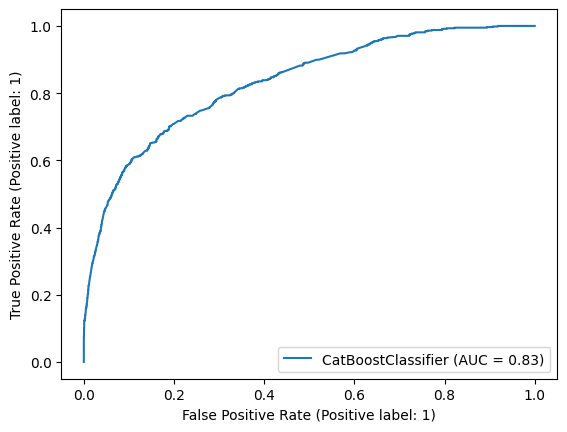

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer

print('AUC = %.2f' % roc_auc_score(y_test.to_numpy(), y_test_pred1['canc_prob']))  #1


metrics.plot_roc_curve(cb, x_test, y_test, ax=plt.gca())  #2
plt.show()

## Scoring Rejected ACH Pulls

### OOT Time Period

In [3349]:
# df_reject = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')

# EXTERNAL BANK
# df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')
# df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_external_bank.csv')

# df_reject = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')
# rejected_ach_transactions_external_account_not_linked

# BANK RISK IND
df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')
df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_bank_risk_ind.csv')

df_reject = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')

values = {'BANK_RISK': 0}
df_reject.fillna(value=values, inplace=True)
df_reject.BANK_RISK = df_reject.BANK_RISK.astype(int)


# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>2) & (df_reject['INDICATOR']==0)]
df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>1) & (df_reject['AGE_BUSINESS_MONTHS']<6)]
# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']<=1)]

df_reject1['INDICATOR'] = df_reject1['INDICATOR'].map({0: 1, 1: 1})

df_reject1.columns = [x.lower() for x in df_reject1.columns]

df_reject1 = df_reject1.loc[(df_reject1['created_at']>='2023-06-01') & (df_reject1['created_at']<'2023-10-01')]
df_reject1 = df_reject1.reset_index()



x_test = df_reject1[['avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
# x_test = df_reject1[['avg_running_balance_past30d','bank_risk','rb_at_deposit','completed_past30d_vs_current_amount_score','card_txn_count_past30d','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]

y_test = df_reject1['indicator']

y_test_pred = cb.predict_proba(x_test)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])


# Rejected Population at different cutoffs
prob_threshold =[0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
reject_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    reject_ls.append(calculate_at_threshold(bin, df_reject1['indicator'], y_test_pred1['canc_prob']))
metric_df_reject = pd.DataFrame(reject_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_reject.index.name = 'Threshold'
metric_df_reject = metric_df_reject.reset_index()
metric_df_reject


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.06,0,297,32,0,0.902736,NaN,1.0,0.902736
1,0.08,0,256,73,0,0.778116,NaN,1.0,0.778116
2,0.10,0,240,89,0,0.729483,NaN,1.0,0.729483
3,0.15,0,164,165,0,0.498480,NaN,1.0,0.498480
4,0.20,0,114,215,0,0.346505,NaN,1.0,0.346505
5,0.30,0,65,264,0,0.197568,NaN,1.0,0.197568
6,0.40,0,41,288,0,0.124620,NaN,1.0,0.124620
7,0.50,0,20,309,0,0.060790,NaN,1.0,0.060790
8,0.60,0,4,325,0,0.012158,NaN,1.0,0.012158
9,0.70,0,2,327,0,0.006079,NaN,1.0,0.006079


In [3350]:
x_test = x_test.reset_index()
test1 = pd.merge(y_test_pred1,x_test, left_index=True, right_index=True)
test2 = test1[['canc_prob','amount']]
print(test1.amount.sum())
for bin in prob_threshold:
    test3 = test2.loc[(test2['canc_prob']>=bin)]
    print(test3.amount.sum())

197982.01
172660.15000000002
142826.09000000003
131679.09
77743.09
50539.21
21710.54
12989.54
8428.54
1400.0
1020.0
50.0


# SHAP Testing

In [126]:
import shap

In [127]:
from catboost import CatBoostClassifier, Pool

In [128]:
shap.initjs()

In [129]:
explainer = shap.TreeExplainer(cb)

In [132]:
filter_x_oot = x_oot[x_oot.index == 19819]
filter_y_oot = y_oot[y_oot.index == 19819]
filter_x_oot.head()

,avg_running_balance_past30d,bank_risk,rb_at_deposit,completed_past30d_vs_current_amount_score,past30d_returned_ach,card_txn_count_past30d,returned_past30d_avg_ach_amount,stddev_running_balance_past30d,ach_c_avg_past30d,od_count_past30d,ach_c_count_past10by30d,amount,ach_c_median_past30d,card_txn_avg_past30d,past30d_avg_ach_amount,debit_txn_count_past10by30d,ach_c_std_past30d,card_txn_median_past10by30d,card_txn_median_past30d,ach_c_median_past10by30d,debit_by_credit_past_30d,rejected_past30d_avg_ach_amount,ein_ssn
19819,NaN,3,NaN,NaN,0,0,0.0,NaN,NaN,NaN,NaN,0.92,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0


In [133]:
shap_values = explainer.shap_values(Pool(filter_x_oot, filter_y_oot, cat_features=categoricals))
shap.force_plot(explainer.expected_value, shap_values[0,:], filter_x_oot.iloc[0,:])


In [106]:
test = x_train.head(1)
shap_values = explainer.shap_values(test)
shap_values
pd.DataFrame(shap_values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-0.456075,-0.085486,-0.015142,-0.024976,0.114273,-0.16515,0.125072,-0.166094,0.06324,-0.008396,-0.019594,0.108546,0.02816,0.091848,-0.021913,-0.020348,-0.023153,0.027819,0.20998,0.068506,0.015304,-0.044993,-0.008662,-0.040562,-0.032107,0.008798,0.12721,-0.072927,0.292149,-0.126379,-0.017985,0.030195,-0.052868,0.04844,-0.013462,-0.010977,-0.013178,0.066316,-0.027441,0.003944


In [104]:
#Reject
shap.force_plot(explainer.expected_value, shap_values[13,:], x_train.iloc[13,:])

In [98]:
#Reject
shap.force_plot(explainer.expected_value, shap_values[95,:], x_train.iloc[95,:])

In [99]:
#Accept
shap.force_plot(explainer.expected_value, shap_values[5,:], x_train.iloc[5,:])

In [100]:
#Accept
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [159]:
# shap.summary_plot(shap_values, max_display=15, show=False)

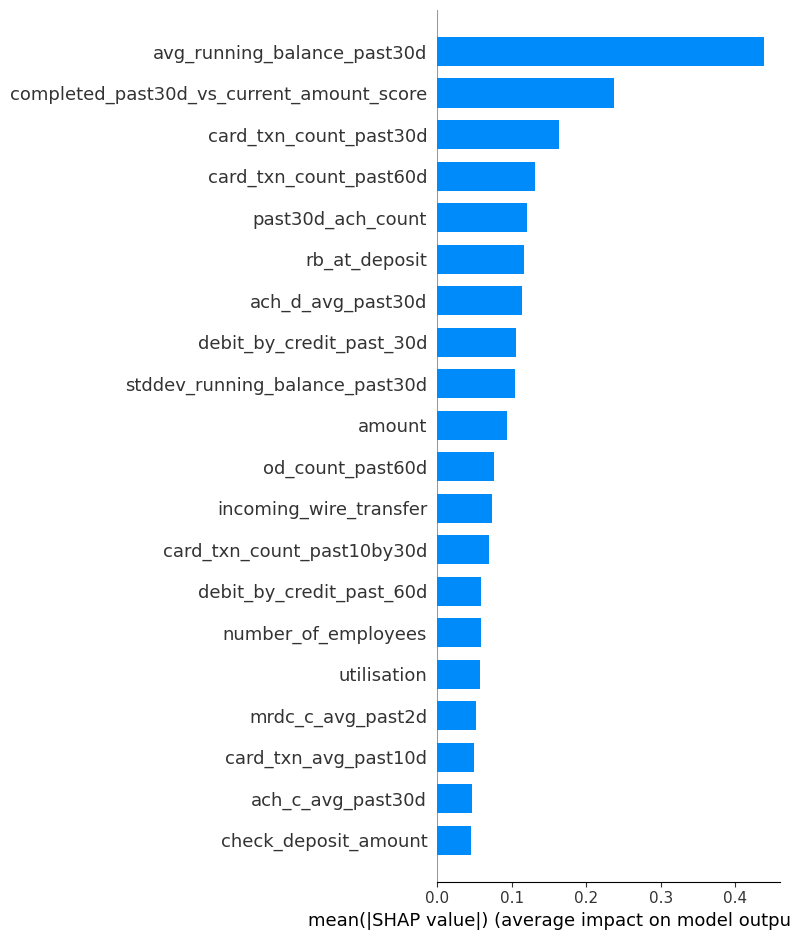

In [100]:
shap.summary_plot(shap_values, x_train, plot_type="bar")
# shap.plots.waterfall(shap_values[0])

In [117]:
# x_train.loc[x_train['index']==13]
pd.DataFrame(shap_values[13,:])

,0
0,0.039895
1,0.819432
2,-0.016213
3,-0.018094
4,0.695446
5,-0.176156
6,0.190528
7,0.071781
8,-0.035266
9,-0.005253
